**Candidate Number:** 179535

# Big Data Coursework - UK Vehicle Dataset - Individual Part

**Table of Contents**
1. Business Objective
2. Setting up Enviroment
3. Data Pre-processing
4. Exploratory Data Analysis
5. Cleaning and Transformation
6. Feature Selection
7. Model Building
8. Conclusion
9. Possible Future Improvement

# 1. Business Objective

In our group work, we comprehensively studied different elements (environmental, individualistic,vehicular,
geographical and road related factors) leading to fatal/non-fatal accidents. With a view to provide insurance companies with a useful predictive model, I'd like to delve deeper into the individual factors, such as demographics (age, sex of drivers, drive home area, etc.) to better understand drivers' driving behaviours, as well as drivers' vehicle factors (vehicle type, vehicle age, engine capacity, and so on) to assess drivers' accident risk.

These details can be easily gathered by insurance companies when the driver signs up for coverage. Insurance companies can then create classification models to **predict level of accident severity** that the drivers can potentially cause. These predictions can be used by insurers to better price and tailor coverage alternatives, as well as to alert clients to take preventative measures.  Both insurers and drivers should gain from this predictive classification model.

This workbook aims to build a classification model that achieve the best possible accuracy score with the information provided. From our group analysis, because 2020 is an unusual year (fewer accidents due to Covid-19 lockdown), I will utilise the 2019 dataset to create a more realistic model. Furthermore, in this analysis, the classification model is only fitted for the over 75 year-old age group, as they are the most vunerable group to fatality (When compared to other age groups, there are three times as many deadly instances) yet they are capable of changing their driving behaviors.

# 2. Setting up Environment

I will repeat some of the steps from the group project to pre-process the data before building a model. Therefore, many codes from the group work are also used in section 2,3,4,5.

In [105]:
# import the required libraries

# base libraries
import os
import time


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

# Data manipulation
import numpy as np
import pandas as pd

# Data Pre-processing and transformation
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from functools import reduce

#confusion matrix 
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

#model
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier

#imbalance
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from sklearn.ensemble import RandomForestClassifier

# do not print warnings
import warnings
warnings.filterwarnings("ignore")

In [106]:
def evaluate_on_test(model, ytest, Xtest):
    yhat = model.predict(Xtest)
    print(classification_report(ytest, yhat))

# 3.Data Pre-Processing


## 3.1 Data Loading and Preparation

In [31]:
# import datasets onto python and save in dataframe
vehicle = pd.read_csv("dft-road-casualty-statistics-vehicle-2019.csv")
accidents = pd.read_csv("dft-road-casualty-statistics-accident-2019.csv")
# import the dataset guide file that will provide us with labels for Cat variables
guide = pd.read_excel("Road-Safety-Open-Dataset-Data-Guide.xlsx", header=0)
guide = guide.drop('note', axis=1)

In [32]:
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216381 entries, 0 to 216380
Data columns (total 27 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   accident_index                    216381 non-null  object
 1   accident_year                     216381 non-null  int64 
 2   accident_reference                216381 non-null  object
 3   vehicle_reference                 216381 non-null  int64 
 4   vehicle_type                      216381 non-null  int64 
 5   towing_and_articulation           216381 non-null  int64 
 6   vehicle_manoeuvre                 216381 non-null  int64 
 7   vehicle_direction_from            216381 non-null  int64 
 8   vehicle_direction_to              216381 non-null  int64 
 9   vehicle_location_restricted_lane  216381 non-null  int64 
 10  junction_location                 216381 non-null  int64 
 11  skidding_and_overturning          216381 non-null  int64 
 12  hi

The choosen independent variables from the 3 dataset are: vehicle type, age of driver, age band of driver, sex of driver, age of vehicle, driver home area type, engine capacity, driver's deprivation index band, propulsion mode. They are easily collected when the driver signs up for insurance, so this experiment is realistic and can be replicated by insurance companies.

In [33]:
# With the necessary variables identified, we'll now proceed to remove any redundant variables

# we assign a list with all the columns we require in each of the 3 datasets below
accidentrequired = ["accident_index", "accident_severity"]

# next we run a loop over the accidents dataset to only keep columns in the previous list
for column in accidents:
    if column not in accidentrequired:
        del accidents[column]

# Repeat above process for the vehicle dataset

vehiclerequired = ["accident_index", "vehicle_type", "age_of_driver", 'age_band_of_driver', "sex_of_driver",
                "age_of_vehicle", "driver_home_area_type","engine_capacity_cc","driver_imd_decile","propulsion_code",
                 "generic_make_model"]

for column in vehicle:
    if column not in vehiclerequired:
        del vehicle[column]

## 3.2 Mapping Categorical Variable Labels

In [34]:
# get the label data as a grouped object from the data guide
g = guide.groupby(guide['field name'])
n= list(g.groups.keys())

In [35]:
# define a function to create individual dictionaries for each categorical variable and value pair
def getfunc(object, column):
    
    # gets the group corresponding to the categorical column and drops non-required columns
    x = object.get_group(column).drop(columns=['table', 'field name'])

    # convert the object to a dictionary with only the code/format and label columns remaining
    x = x.set_index('code/format')['label'].to_dict()

    return x 

# we can use this function for all of our datasets

In [36]:
# Create a list with all the column names of the variables that need to be mapped
listdf =["vehicle_type", 'age_band_of_driver', "sex_of_driver", "driver_home_area_type","driver_imd_decile","propulsion_code"]


In [37]:
#Create a for loop to replace the label with the label from the guide
for col in listdf:
    if col in n:
         vehicle[col] = vehicle[col].map(getfunc(g,col))

In [38]:
#we replace columns with the label dictionaries we get from applying the above function to grouped object
accidents['accident_severity'] = accidents['accident_severity'].map(getfunc(g, "accident_severity"))

In [39]:
vehicle.head()

,accident_index,vehicle_type,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type
0,2019010128300,Car,Male,58,56 - 65,-1,Undefined,-1,-1,More deprived 10-20%,Urban area
1,2019010128300,Car,Not known,-1,Data missing or out of range,-1,Undefined,-1,-1,More deprived 10-20%,Urban area
2,2019010152270,Car,Female,24,21 - 25,-1,Undefined,-1,-1,More deprived 20-30%,Urban area
3,2019010152270,Car,Not known,-1,Data missing or out of range,-1,Undefined,-1,-1,Less deprived 40-50%,Urban area
4,2019010155191,Car,Male,45,36 - 45,-1,Undefined,-1,-1,More deprived 30-40%,Urban area


## 3.3 Merging and Joining our Dataframes

In [40]:
# merging both dataframes
# we merge the dataframes as 'inner' to ensure only accident data observed in all 3 datasets are merged. 
df2 = vehicle.merge(accidents,on='accident_index', how='inner')
# inspect the dimensions of our new combined dataset and drop any duplicates
print(df2.shape)
df2.drop_duplicates(keep ='first', inplace = True)
print(df2.shape)

(175665, 12)
(175227, 12)


## 3.4 Mapping unknown data (Coded as -1)

In [41]:
# check for missing (NaN) values in our dataset before replacing
df2.isnull().sum()

accident_index           0
vehicle_type             0
sex_of_driver            0
age_of_driver            0
age_band_of_driver       0
engine_capacity_cc       0
propulsion_code          0
age_of_vehicle           0
generic_make_model       0
driver_imd_decile        0
driver_home_area_type    0
accident_severity        0
dtype: int64

In [42]:
# replace all values in the dataset coded -1 to be Null
df2.replace(-1, np.nan, inplace=True)

In [43]:
# some values in the dataset have been mapped as 'Data Missing' or 'Unknown' during mapping in 3.2
# We will also replace these values as null same as those above
to_remove = ['Data missing or out of range', 'unknown (self reported)', 
            'Unknown vehicle type (self rep only)','Not known','Unknown','Unknown or other',
             'Undefined']

df2.replace(to_replace=to_remove, value=np.nan, inplace=True)

In [44]:
df2.isnull().sum()

accident_index                0
vehicle_type                175
sex_of_driver             19711
age_of_driver             24389
age_band_of_driver        24389
engine_capacity_cc        45597
propulsion_code           45188
age_of_vehicle            45257
generic_make_model       175227
driver_imd_decile         35753
driver_home_area_type     35738
accident_severity             0
dtype: int64

In [45]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175227 entries, 0 to 175664
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   accident_index         175227 non-null  object 
 1   vehicle_type           175052 non-null  object 
 2   sex_of_driver          155516 non-null  object 
 3   age_of_driver          150838 non-null  float64
 4   age_band_of_driver     150838 non-null  object 
 5   engine_capacity_cc     129630 non-null  float64
 6   propulsion_code        130039 non-null  object 
 7   age_of_vehicle         129970 non-null  float64
 8   generic_make_model     0 non-null       float64
 9   driver_imd_decile      139474 non-null  object 
 10  driver_home_area_type  139489 non-null  object 
 11  accident_severity      175227 non-null  object 
dtypes: float64(4), object(8)
memory usage: 17.4+ MB


In [46]:
#generic_make_model does not have any non-null value, so we remove it
df2=df2.drop(columns=['accident_index','generic_make_model'])

## 3.5 Transform the target

In [47]:
# We will only consider fatal vs non-fatal data
# define a function to create the required feature column on a given dataset
def extractfatality(data, column, target):
    
    # create new column equivalent to true or false from the given column target combination
    data[target] = data[column] == target

    # replace true, and false values in the new column as 1, and 0 respectively
    data.replace({True:1,False:0}, inplace=True)

    # drop the original column used to create our feature column
    data.drop(column, axis=1, inplace=True)

    return data

# run the function on both training and test sets
df2 = extractfatality(df2, 'accident_severity', 'Fatal')


## 3.6 Focus on age band over 75

In [48]:
#calculate the percentage of fatal cases in each age band
#group and count the total number of accident cases in each age group
total = df2.groupby('age_band_of_driver').size()\
                                                .reset_index(name='total')\
                                                    .sort_values(by='age_band_of_driver',ascending=False)
#group and count the number of deadly accident cases in each age group
fatal = df2[df2['Fatal']==1]
fatal = fatal.groupby('age_band_of_driver').size()\
                                                .reset_index(name='fatal')\
                                                    .sort_values(by='age_band_of_driver',ascending=False)

#calculate the percentage of fatality in each age group
percent = total.merge(fatal,on='age_band_of_driver', how='inner')
percent['percent %'] = percent['fatal'] / percent['total'] * 100
percent

,age_band_of_driver,total,fatal,percent %
0,Over 75,4881,175,3.585331
1,66 - 75,7896,196,2.482270
2,56 - 65,16348,341,2.085882
3,46 - 55,26096,479,1.835530
4,36 - 45,28310,393,1.388202
5,26 - 35,37748,465,1.231853
6,21 - 25,16730,226,1.350867
7,16 - 20,11102,143,1.288056
8,11 - 15,1382,11,0.795948
9,0 - 5,35,1,2.857143


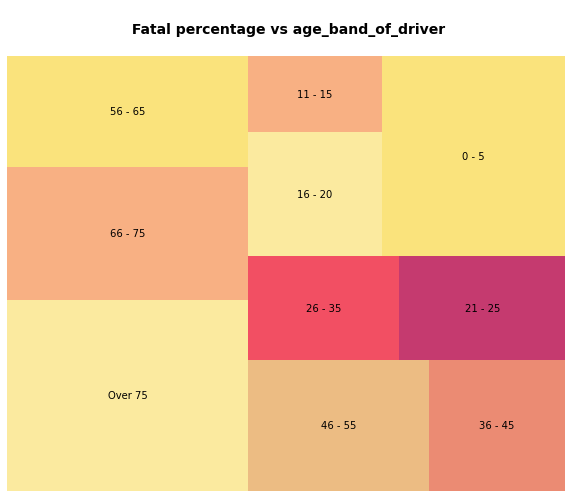

In [49]:
#draw a treemap
fig, ax = plt.subplots(1, figsize = (10,8))
colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c']
squarify.plot(sizes=percent['percent %'], 
              label=percent['age_band_of_driver'][:10], color = colors,
              alpha=.8 )
plt.title('\n Fatal percentage vs age_band_of_driver\n', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

People over the age of 75 are the most susceptible to traffic deaths, accounting for 3.58 percent of all fatalities. Drivers in the age groups 0-5 are likewise particularly vulnerable to mortality (2.86%), but they are at an age in which they are unaware of the driving activities, therefore it is more appropriate to argue that their parents (who belongs to other age groups) are responsible. At the same time, overall incidents involving drivers aged 0 to 5 are extremely rare, with only 35 cases reported. As a result, it's vital to analyse and predict the driving patterns of people over 75, because this is the group in which an improvement in insurance firms' pricing strategies would have the greatest influence compared to other groups. At the same time, over 75 drivers are capable of utilizing the information provided to take precautionary measures. 

In [50]:
# Create a new dataset with information of only drivers over 75 years old
df2 = df2[df2['age_band_of_driver']=='Over 75']

#drop the age_band_of_driver column
df2 = df2.drop('age_band_of_driver', 1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4881 entries, 15 to 175663
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   vehicle_type           4880 non-null   object 
 1   sex_of_driver          4855 non-null   object 
 2   age_of_driver          4881 non-null   float64
 3   engine_capacity_cc     4246 non-null   float64
 4   propulsion_code        4254 non-null   object 
 5   age_of_vehicle         4248 non-null   float64
 6   driver_imd_decile      4496 non-null   object 
 7   driver_home_area_type  4497 non-null   object 
 8   Fatal                  4881 non-null   int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 381.3+ KB


In [51]:
# check for missing (NaN) values in our new dataset 
df2.isnull().sum()

vehicle_type               1
sex_of_driver             26
age_of_driver              0
engine_capacity_cc       635
propulsion_code          627
age_of_vehicle           633
driver_imd_decile        385
driver_home_area_type    384
Fatal                      0
dtype: int64

## 3.6 Train-Test Split 

In [52]:
# once we have preliminary dataset ready, we'll need to split them into train and test sets

# import the Stratified Shuffle Split class from sklearn
from sklearn.model_selection import StratifiedShuffleSplit

# instantiate a stratified splitter class with test size of 20%
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=7)

# the stratified splitter provides integer values as indexes on the original dataset df2
train_index, test_index = list(stratified_splitter.split(df2, df2['Fatal']))[0]

# we take all rows with corresponding index values matching with both train_index and df2 to trainset
trainset = df2.iloc[train_index]

# same process for test set as we did for our training set
testset = df2.iloc[test_index]

# verify the dimensions of the datasets
print(f"{trainset.shape[0]} train and {testset.shape[0]} test instances")

3904 train and 977 test instances


In [53]:
# As we have used the stratified split, we can check for the proportionality of our split.

# define a function to return the proportion of respective accident severities
def severity_proportions(data):
    return data["Fatal"].value_counts() / len(data)

# create a random split
rand_train_set, rand_test_set = train_test_split(df2, test_size=0.2, random_state=7)

# create a temporary dataframe for easy visualization
df_tmp = pd.DataFrame({
    "Overall": severity_proportions(df2),
    "Random test set": severity_proportions(rand_test_set),
    "Stratified test set": severity_proportions(testset),
}).sort_index()

# add two columns for the percent of the difference to the overall proportion
df_tmp["Rand. %error"] = 100 * df_tmp["Random test set"] / df_tmp["Overall"] - 100
df_tmp["Strat. %error"] = 100 * df_tmp["Stratified test set"] / df_tmp["Overall"] - 100

df_tmp

,Overall,Random test set,Stratified test set,Rand. %error,Strat. %error
0,0.964147,0.959058,0.964176,-0.527757,0.003045
1,0.035853,0.040942,0.035824,14.192133,-0.081883


# 4. Exploratory Data Analysis

## 4.1 Target Exploration

In [54]:
# Calculate the percentage of total accidents in each severity category
severity = round(trainset.loc[:,'Fatal'].value_counts(normalize=True),4)
severity= severity.mul(100).rename('Percent').reset_index()
severity= severity.rename({'index':'Fatal'}, axis =1)
severity

,Fatal,Percent
0,0,96.41
1,1,3.59


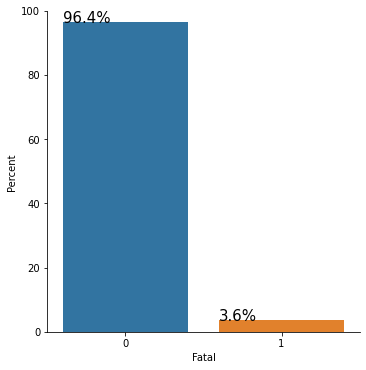

In [55]:
#Visualize accident severity
g = sns.catplot(x= 'Fatal', y= 'Percent', kind='bar', data=severity)
g.ax.set_ylim(0,100)
for p in g.ax.patches:
        txt = str(p.get_height().round(1)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt, fontsize=15)

From the graph, we can see an imbalance in the 2 categories, fatal vs non-fatal. Non-fatal cases accounts for 98.6% of the total cases while deadly accidents only account for 1.5%. I am going to address this issue when building the model.

## 4.2 Numerical Data Exploration

array([[<AxesSubplot:title={'center':'age_of_driver'}>,
        <AxesSubplot:title={'center':'engine_capacity_cc'}>],
       [<AxesSubplot:title={'center':'age_of_vehicle'}>, <AxesSubplot:>]],
      dtype=object)

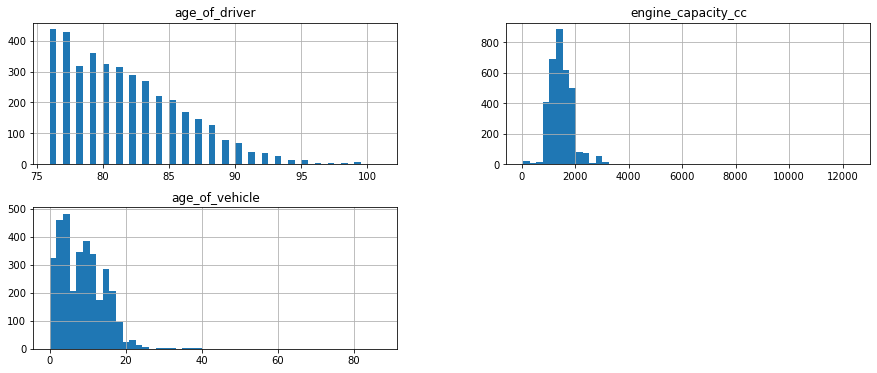

In [56]:
# plot a histogram containing all numerical variables in the dataset.
numerical_vis = trainset.drop('Fatal', 1)
numerical_vis.hist(bins=50, figsize=(15,6), histtype='bar')

Age of driver and age of vehicle are right-skewed. The 2 plots suggests that there might be some correlations between the 2 variables. 

## 4.3 Categorical Data Exploration

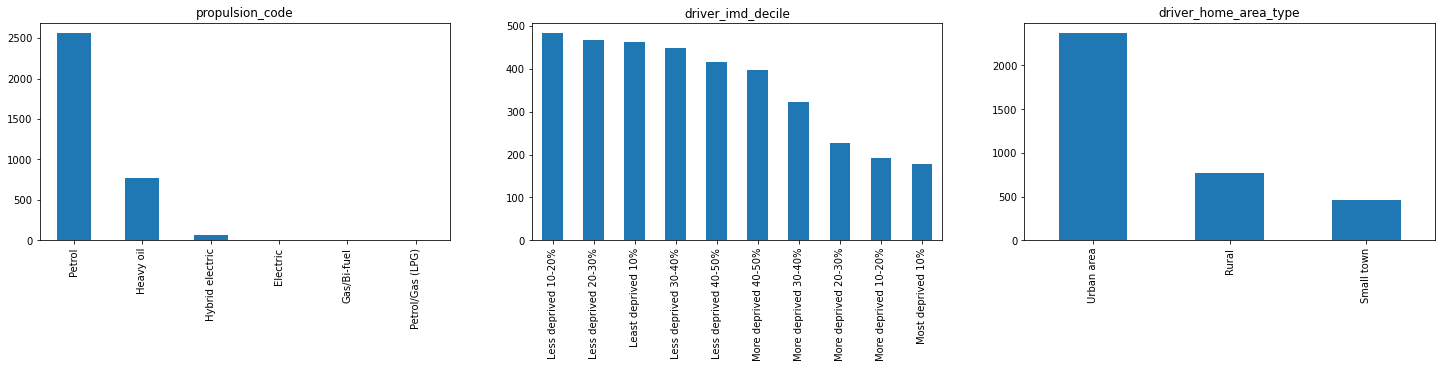

In [57]:
# graphs for categorical variables
categorical_features = ["propulsion_code","driver_imd_decile","driver_home_area_type"]
fig, ax = plt.subplots(1, len(categorical_features))
for i, categorical_feature in enumerate(trainset[categorical_features]):
    trainset[categorical_feature].value_counts().plot(kind='bar', figsize=(25, 4),ax=ax[i]).set_title(categorical_feature)
fig.show()

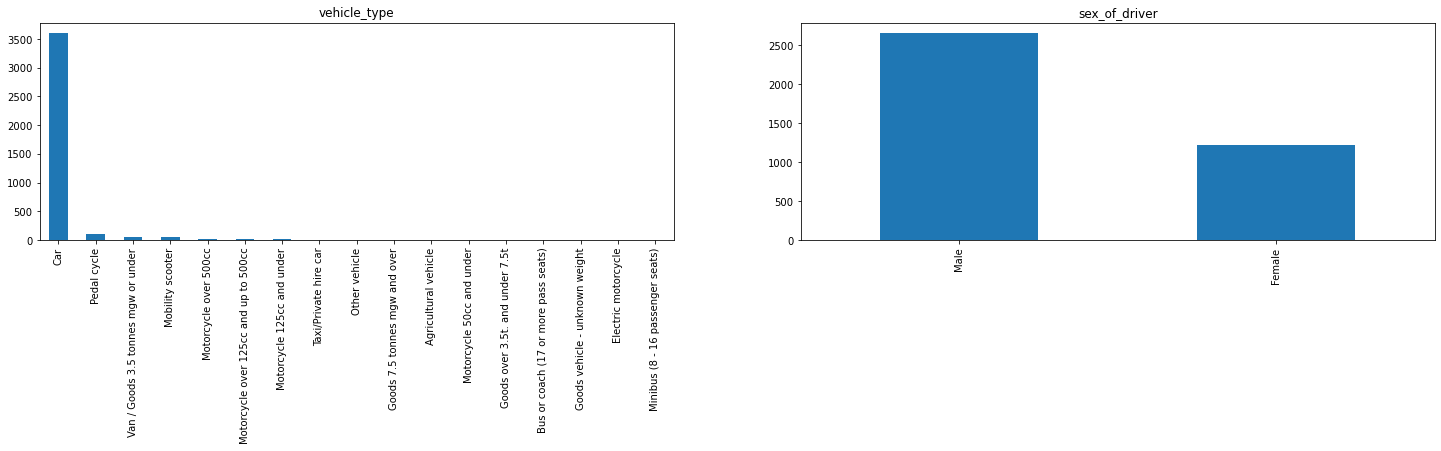

In [58]:
# graphs for categorical variables
categorical_features = ["vehicle_type","sex_of_driver"]
fig, ax = plt.subplots(1, len(categorical_features))
for i, categorical_feature in enumerate(trainset[categorical_features]):
    trainset[categorical_feature].value_counts().plot(kind='bar', figsize=(25, 4),ax=ax[i]).set_title(categorical_feature)
fig.show()

Car accidents occur in a disproportionately large quantity compared to other types of accidents. It's possible that we'll need to combine the groups into larger groupings. Similarly, there most of the propulsion type are petrol and oils, suggesting potential groupings. 

# 5. Cleaning Dataset and Transformations

## 5.1. Feature Engineering

In [59]:
# we will group vehicle type to fewer groups
trainset['vehicle_type'] = trainset['vehicle_type'].replace(['Goods 7.5 tonnes mgw and over',
                                                             "Bus or coach (17 or more pass seats)",
                                                             "Motorcycle over 125cc and up to 500cc",
                                                             "Motorcycle 50cc and under", "Other vehicle",
                                                             "Goods vehicle - unknown weight",
                                                             "Goods over 3.5t. and under 7.5t","Agricultural vehicle",
                                                             "Motorcycle - unknown cc","Minibus (8 - 16 passenger seats)",
                                                             "Mobility scooter", "Ridden horse","Electric motorcycle",
                                                             "Tram",'Van / Goods 3.5 tonnes mgw or under',
                                                            'Motorcycle 125cc and under',
                                                            'Motorcycle over 500cc',
                                                            'Taxi/Private hire car'],'Other vehicle')

<AxesSubplot:>

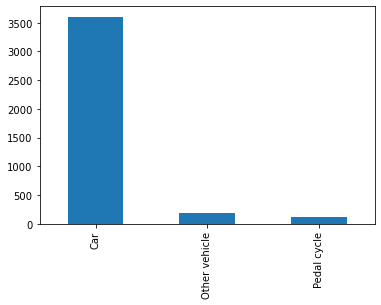

In [60]:
trainset['vehicle_type'].value_counts().plot(kind='bar')

In [61]:
# Do a similar grouping on the testset
testset['vehicle_type'] = testset['vehicle_type'].replace(['Goods 7.5 tonnes mgw and over',
                                                             "Bus or coach (17 or more pass seats)",
                                                             "Motorcycle over 125cc and up to 500cc",
                                                             "Motorcycle 50cc and under", "Other vehicle",
                                                             "Goods vehicle - unknown weight",
                                                             "Goods over 3.5t. and under 7.5t","Agricultural vehicle",
                                                             "Motorcycle - unknown cc","Minibus (8 - 16 passenger seats)",
                                                             "Mobility scooter", "Ridden horse","Electric motorcycle",
                                                             "Tram",'Van / Goods 3.5 tonnes mgw or under',
                                                            'Motorcycle 125cc and under',
                                                            'Motorcycle over 500cc',
                                                            'Taxi/Private hire car'],'Other vehicle')

In [62]:
# we will group propulsion to fewer groups
trainset['propulsion_code'] = trainset['propulsion_code'].replace(['Electric',
                                                             "Bus or coach (17 or more pass seats)",
                                                             "Gas/Bi-fuel",
                                                             "Electric diesel", "Gas",
                                                             "Petrol/Gas (LPG)",
                                                             "New fuel technology","Gas Diesel",
                                                             "Steam",'Hybrid electric'],'Other propulsion type')

<AxesSubplot:>

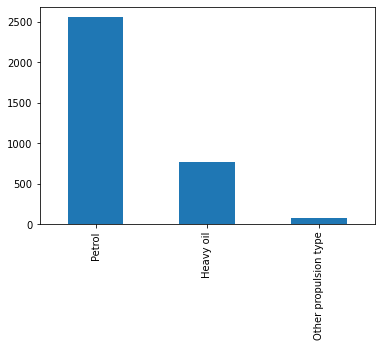

In [63]:
trainset['propulsion_code'].value_counts().plot(kind='bar')

In [64]:
# Do a similar grouping on the testset
testset['propulsion_code'] = testset['propulsion_code'].replace(['Electric',
                                                             "Bus or coach (17 or more pass seats)",
                                                             "Gas/Bi-fuel",
                                                             "Electric diesel", "Gas",
                                                             "Petrol/Gas (LPG)",
                                                             "New fuel technology","Gas Diesel",
                                                             "Steam",'Hybrid electric'],'Other propulsion type')

## 5.2 Handling Missing Values

In [65]:
trainset.isnull().sum()

vehicle_type               0
sex_of_driver             25
age_of_driver              0
engine_capacity_cc       505
propulsion_code          499
age_of_vehicle           503
driver_imd_decile        307
driver_home_area_type    306
Fatal                      0
dtype: int64

### 5.2.1 Handle numerical missing values

In [66]:
# import the SimpleImputer class and instantiate the object
from sklearn.impute import SimpleImputer

# instantiate imputer object with median
imputer = SimpleImputer(strategy ='median')

# define a function that imputes missing values on a given train,test dataset pair.
def imputefunc(trainset, testset):
    
    # seperate features into numerical and categorical sets
    trainset_num = trainset.select_dtypes(include=['float64'])
    trainset_cat = trainset.select_dtypes(include=['object','int64'])

    testset_num = testset.select_dtypes(include=['float64'])
    testset_cat = testset.select_dtypes(include=['object','int64'])

    # fit the impute on our training set and subsequently transform both sets
    trainset = pd.DataFrame(imputer.fit_transform(trainset_num),columns = trainset_num.columns)
    testset = pd.DataFrame(imputer.transform(testset_num), columns = testset_num.columns)
    
    # reset the index of both our sets as concatenation requires consistent indexes
    trainset_cat.reset_index(level=0, inplace=True)
    testset_cat.reset_index(level=0, inplace=True)  

    # drop the old indexes of the train and test set categoricals
    trainset_cat.drop(columns='index', axis=1, inplace=True)
    testset_cat.drop(columns='index', axis=1, inplace=True)

    # next we join back the two dataframes 
    trainset = pd.concat([trainset, trainset_cat], axis=1)
    testset = pd.concat([testset, testset_cat], axis=1)

    return trainset, testset


trainset, testset = imputefunc(trainset, testset)

In [67]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age_of_driver          3904 non-null   float64
 1   engine_capacity_cc     3904 non-null   float64
 2   age_of_vehicle         3904 non-null   float64
 3   vehicle_type           3904 non-null   object 
 4   sex_of_driver          3879 non-null   object 
 5   propulsion_code        3405 non-null   object 
 6   driver_imd_decile      3597 non-null   object 
 7   driver_home_area_type  3598 non-null   object 
 8   Fatal                  3904 non-null   int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 274.6+ KB


## 5.2.2 handle categorical missing values

In [68]:
# import the SimpleImputer class and instantiate the object
from sklearn.impute import SimpleImputer

# instantiate imputer object with median
imputer = SimpleImputer(strategy ='most_frequent')

# define a function that imputes missing values on a given train,test dataset pair.
def imputefunc(trainset, testset):
    
    # seperate features into numerical and categorical sets
    trainset_num = trainset.select_dtypes(include=['float64','int64'])
    trainset_cat = trainset.select_dtypes(include=['object'])

    testset_num = testset.select_dtypes(include=['float64','int64'])
    testset_cat = testset.select_dtypes(include=['object'])

    # fit the impute on our training set and subsequently transform both sets
    trainset = pd.DataFrame(imputer.fit_transform(trainset_cat),columns = trainset_cat.columns)
    testset = pd.DataFrame(imputer.transform(testset_cat), columns = testset_cat.columns)
    
    # reset the index of both our sets as concatenation requires consistent indexes
    trainset_num.reset_index(level=0, inplace=True)
    testset_num.reset_index(level=0, inplace=True)  

    # drop the old indexes of the train and test set categoricals
    trainset_num.drop(columns='index', axis=1, inplace=True)
    testset_num.drop(columns='index', axis=1, inplace=True)

    # next we join back the two dataframes 
    trainset = pd.concat([trainset, trainset_num], axis=1)
    testset = pd.concat([testset, testset_num], axis=1)

    return trainset, testset


trainset, testset = imputefunc(trainset, testset)

In [69]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   vehicle_type           3904 non-null   object 
 1   sex_of_driver          3904 non-null   object 
 2   propulsion_code        3904 non-null   object 
 3   driver_imd_decile      3904 non-null   object 
 4   driver_home_area_type  3904 non-null   object 
 5   age_of_driver          3904 non-null   float64
 6   engine_capacity_cc     3904 non-null   float64
 7   age_of_vehicle         3904 non-null   float64
 8   Fatal                  3904 non-null   int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 274.6+ KB


## 5.3 Encoding Dummy Variables

In [70]:
# import the onehotencoder class to implement encoding
from sklearn.preprocessing import OneHotEncoder


# set aside the categorical columns as a list object 
catcols = trainset.select_dtypes(['object']).columns.tolist()

# define the get dummies function to return encoded train and test sets
def get_dummies(trainset, testset, old_col_name):
    """Given a trainset, a testset, and the name of a column holding a 
    categorical variable, fit an encoder on the trainset, and use the 
    encoder to add dummy columns into the trainset and testset
    """
    
    one_hot_encoder = OneHotEncoder(drop="first", sparse=False)
    
    # the input to the encoder must be a 2-d numpy array,
    # so we take the column, extract their values and reshape the array to be 2-d
    # the old_col_name will be taken from the categorical columns list defined previously
    cat_vals = trainset[old_col_name].values.reshape(-1,1)

    # fit an encoder and transform the **trainset**
    # the output is a new numpy array
    transformed = one_hot_encoder.fit_transform(cat_vals)
    
    # in the list of new columns, convert numpy array to a list and
    # drop the first column, because we requested "drop='first'"
    new_col_names = one_hot_encoder.categories_[0].tolist()[1:]
    
    for i, new_col_name in enumerate(new_col_names):
        
        # put the transformed data as columns in the trainset dataframe
        trainset[new_col_name] = transformed[:,i]
    
    # transform the **testset** using the fitted encoder
    
    cat_vals = testset[old_col_name].values.reshape(-1,1)
    transformed = one_hot_encoder.transform(cat_vals)

    for i, new_col_name in enumerate(new_col_names):
        
        # put the transformed data as columns in the testset dataframe
        testset[new_col_name] = transformed[:,i]
    
    return trainset, testset


for col_name in catcols:
    trainset, testset = get_dummies(trainset, testset, col_name)

# check if the dummies are produced correctly in the trainset
trainset.head()


,vehicle_type,sex_of_driver,propulsion_code,driver_imd_decile,driver_home_area_type,age_of_driver,engine_capacity_cc,age_of_vehicle,Fatal,Other vehicle,...,Less deprived 20-30%,Less deprived 30-40%,Less deprived 40-50%,More deprived 10-20%,More deprived 20-30%,More deprived 30-40%,More deprived 40-50%,Most deprived 10%,Small town,Urban area
0,Car,Female,Petrol,Less deprived 10-20%,Small town,79.0,998.0,7.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Car,Male,Petrol,Most deprived 10%,Urban area,78.0,1398.0,3.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,Car,Male,Petrol,Less deprived 30-40%,Rural,77.0,1598.0,12.0,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Car,Male,Petrol,More deprived 30-40%,Rural,83.0,999.0,5.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Car,Male,Petrol,Less deprived 40-50%,Rural,91.0,1199.0,17.0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
# with our dummy variables in place, we no longer need old columns
def dropfunc(data, column_list):
    for column in data:
        if column in column_list:
            del data[column]

# implement the above function on the categorical columns list previously defined
dropfunc(trainset, catcols)
dropfunc(testset, catcols)

trainset.head()

,age_of_driver,engine_capacity_cc,age_of_vehicle,Fatal,Other vehicle,Pedal cycle,Male,Other propulsion type,Petrol,Less deprived 10-20%,Less deprived 20-30%,Less deprived 30-40%,Less deprived 40-50%,More deprived 10-20%,More deprived 20-30%,More deprived 30-40%,More deprived 40-50%,Most deprived 10%,Small town,Urban area
0,79.0,998.0,7.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,78.0,1398.0,3.0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,77.0,1598.0,12.0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,83.0,999.0,5.0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,91.0,1199.0,17.0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
# verify the dimensions of the datasets following encoding
print(trainset.shape, testset.shape)

(3904, 20) (977, 20)


## 5.4 Handling Outliers & Anomalies

We will use isolation forest to figure out the anomalies and outliers in the dataset. Here, we strive to create an 'anomaly'column, acting as an indicative variable (flag if an observation is an anomaly or outlier). Removing outliers or converting the outliers to median values can potentially change the dataset shape to normally distributed when it is actually not. 

In [74]:
from sklearn.ensemble import IsolationForest

# fit the trainset into the model
iso_model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(.010),max_features=1.0)
iso_model.fit(trainset)

#create two additional columns to checj the score 
trainset['anomaly']=iso_model.predict(trainset)
trainset['scores']=iso_model.decision_function(trainset)

#print anomaly
print("Percentage of anomalies in trainset: {:.2f}".format((len(trainset.loc[trainset['anomaly']==-1])/len(trainset))*100))

Percentage of anomalies in trainset: 1.02


Here, we created 2 columns, anomaly and scores. Any observations with a value in the 'anomaly'column =-1 is an anomaly. We tuned the contamination parameter to decide the percentage of anomalies in the dataset. 

<AxesSubplot:>

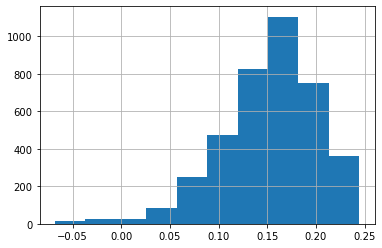

In [75]:
#visualization and tuning
trainset['scores'].hist()

From this graph, we can see that inliers have positive scores and are grouped together on the right. Outliers are all the points on the left of 0 with negative score. I want to flag only the most extreme outliers and after inputing several number for the contamination parameter and observing the graph, it seems that contamination of 0.01 is a suitable one. 

In [76]:
#change the values in the 'anomaly'column:
#normal observation =0
# anomaly = 1
trainset.loc[trainset['anomaly'] == 1,'anomaly'] = 0
trainset.loc[trainset['anomaly'] == -1,'anomaly'] = 1
trainset['anomaly'].value_counts()

0    3864
1      40
Name: anomaly, dtype: int64

In [77]:
#delete scores column on trainset
trainset = trainset.drop('scores', 1)

In [79]:
#repeat the same steps with testset
iso_model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(.010),max_features=1.0)
iso_model.fit(testset)

testset['anomaly']=iso_model.predict(testset)
testset['scores']=iso_model.decision_function(testset)

#delete scores column on trainset
del testset['scores']

#change the values in the 'anomaly'column:
#normal observation =0
# anomaly = 1
testset.loc[testset['anomaly'] == 1,'anomaly'] = 0
testset.loc[testset['anomaly'] == -1,'anomaly'] = 1
testset['anomaly'].value_counts()


0    967
1     10
Name: anomaly, dtype: int64

In [80]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age_of_driver          3904 non-null   float64
 1   engine_capacity_cc     3904 non-null   float64
 2   age_of_vehicle         3904 non-null   float64
 3   Fatal                  3904 non-null   int64  
 4   Other vehicle          3904 non-null   float64
 5   Pedal cycle            3904 non-null   float64
 6   Male                   3904 non-null   float64
 7   Other propulsion type  3904 non-null   float64
 8   Petrol                 3904 non-null   float64
 9   Less deprived 10-20%   3904 non-null   float64
 10  Less deprived 20-30%   3904 non-null   float64
 11  Less deprived 30-40%   3904 non-null   float64
 12  Less deprived 40-50%   3904 non-null   float64
 13  More deprived 10-20%   3904 non-null   float64
 14  More deprived 20-30%   3904 non-null   float64
 15  More

In [81]:
trainset['Fatal'].value_counts()

0    3764
1     140
Name: Fatal, dtype: int64

## 5.5 Feature Scaling

In [82]:
# import the standard scaler class and instantiate the object
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# seperate into predictor and target sets, we do not scale our target
trainset_target = trainset['Fatal'].values
# we do not include and scale date + accident index as part of modelling going forward
trainset_predictors = trainset.drop(columns=['Fatal'], axis=1)

# call the fit and transform method on our predictors
scaled_vals = scaler.fit_transform(trainset_predictors)

# put the scaled values back into the trainset dataframe
trainset = pd.DataFrame(scaled_vals, columns=trainset_predictors.columns)

# put the non-scaled target back in
trainset['Fatal'] = trainset_target

# inspect the data
trainset.head()

,age_of_driver,engine_capacity_cc,age_of_vehicle,Other vehicle,Pedal cycle,Male,Other propulsion type,Petrol,Less deprived 10-20%,Less deprived 20-30%,...,Less deprived 40-50%,More deprived 10-20%,More deprived 20-30%,More deprived 30-40%,More deprived 40-50%,Most deprived 10%,Small town,Urban area,anomaly,Fatal
0,-0.571621,-0.894544,-0.257306,-0.226181,-0.168674,-1.48324,-0.141846,0.525183,1.985390,-0.368611,...,-0.345814,-0.226806,-0.249046,-0.300330,-0.336927,-0.219212,2.729508,-1.475319,-0.101745,0
1,-0.795926,-0.186555,-0.963721,-0.226181,-0.168674,0.67420,-0.141846,0.525183,-0.503679,-0.368611,...,-0.345814,-0.226806,-0.249046,-0.300330,-0.336927,4.561804,-0.366366,0.677819,-0.101745,0
2,-1.020230,0.167439,0.625713,-0.226181,-0.168674,0.67420,-0.141846,0.525183,-0.503679,-0.368611,...,-0.345814,-0.226806,-0.249046,-0.300330,-0.336927,-0.219212,-0.366366,-1.475319,-0.101745,0
3,0.325598,-0.892774,-0.610513,-0.226181,-0.168674,0.67420,-0.141846,0.525183,-0.503679,-0.368611,...,-0.345814,-0.226806,-0.249046,3.329668,-0.336927,-0.219212,-0.366366,-1.475319,-0.101745,0
4,2.120036,-0.538780,1.508732,-0.226181,-0.168674,0.67420,-0.141846,0.525183,-0.503679,-0.368611,...,2.891731,-0.226806,-0.249046,-0.300330,-0.336927,-0.219212,-0.366366,-1.475319,-0.101745,0


In [83]:
# we repeat much of the scaling steps for the test set as well
# the only difference here is that we do not call the fit transform, but only fit

testset_target = testset["Fatal"].values

testset_predictors = testset.drop(columns=["Fatal"], axis=1)

scaled_vals = scaler.transform(testset_predictors)
testset = pd.DataFrame(scaled_vals, columns=testset_predictors.columns)

# put the non-scaled variables back in
testset['Fatal'] = testset_target


 
testset.head()

,age_of_driver,engine_capacity_cc,age_of_vehicle,Other vehicle,Pedal cycle,Male,Other propulsion type,Petrol,Less deprived 10-20%,Less deprived 20-30%,...,Less deprived 40-50%,More deprived 10-20%,More deprived 20-30%,More deprived 30-40%,More deprived 40-50%,Most deprived 10%,Small town,Urban area,anomaly,Fatal
0,-0.347316,-0.239654,0.272505,-0.226181,-0.168674,0.67420,-0.141846,0.525183,-0.503679,-0.368611,...,-0.345814,-0.226806,4.015322,-0.30033,-0.336927,-0.219212,-0.366366,0.677819,-0.101745,0
1,0.549903,-0.540550,-1.140325,-0.226181,-0.168674,-1.48324,-0.141846,0.525183,1.985390,-0.368611,...,-0.345814,-0.226806,-0.249046,-0.30033,-0.336927,-0.219212,2.729508,-1.475319,-0.101745,0
2,0.998512,0.100180,-0.963721,-0.226181,-0.168674,0.67420,-0.141846,-1.904099,-0.503679,-0.368611,...,2.891731,-0.226806,-0.249046,-0.30033,-0.336927,-0.219212,-0.366366,-1.475319,-0.101745,0
3,0.325598,-0.892774,-0.610513,-0.226181,-0.168674,-1.48324,-0.141846,0.525183,1.985390,-0.368611,...,-0.345814,-0.226806,-0.249046,-0.30033,-0.336927,-0.219212,-0.366366,0.677819,-0.101745,0
4,0.325598,-0.188325,1.508732,-0.226181,-0.168674,0.67420,-0.141846,0.525183,-0.503679,-0.368611,...,-0.345814,-0.226806,-0.249046,-0.30033,-0.336927,-0.219212,-0.366366,0.677819,-0.101745,0


In [84]:
# drop labels for training set, but keep all others
Xtrain = trainset.drop("Fatal", axis=1)
Xtest = testset.drop("Fatal", axis=1)


ytrain = trainset["Fatal"].copy()
ytest = testset["Fatal"].copy()

In [85]:
# inspect the train set 
Xtrain.head()

,age_of_driver,engine_capacity_cc,age_of_vehicle,Other vehicle,Pedal cycle,Male,Other propulsion type,Petrol,Less deprived 10-20%,Less deprived 20-30%,Less deprived 30-40%,Less deprived 40-50%,More deprived 10-20%,More deprived 20-30%,More deprived 30-40%,More deprived 40-50%,Most deprived 10%,Small town,Urban area,anomaly
0,-0.571621,-0.894544,-0.257306,-0.226181,-0.168674,-1.48324,-0.141846,0.525183,1.985390,-0.368611,-0.360495,-0.345814,-0.226806,-0.249046,-0.300330,-0.336927,-0.219212,2.729508,-1.475319,-0.101745
1,-0.795926,-0.186555,-0.963721,-0.226181,-0.168674,0.67420,-0.141846,0.525183,-0.503679,-0.368611,-0.360495,-0.345814,-0.226806,-0.249046,-0.300330,-0.336927,4.561804,-0.366366,0.677819,-0.101745
2,-1.020230,0.167439,0.625713,-0.226181,-0.168674,0.67420,-0.141846,0.525183,-0.503679,-0.368611,2.773964,-0.345814,-0.226806,-0.249046,-0.300330,-0.336927,-0.219212,-0.366366,-1.475319,-0.101745
3,0.325598,-0.892774,-0.610513,-0.226181,-0.168674,0.67420,-0.141846,0.525183,-0.503679,-0.368611,-0.360495,-0.345814,-0.226806,-0.249046,3.329668,-0.336927,-0.219212,-0.366366,-1.475319,-0.101745
4,2.120036,-0.538780,1.508732,-0.226181,-0.168674,0.67420,-0.141846,0.525183,-0.503679,-0.368611,-0.360495,2.891731,-0.226806,-0.249046,-0.300330,-0.336927,-0.219212,-0.366366,-1.475319,-0.101745


In [86]:
# inspect the test set
Xtest.head()

,age_of_driver,engine_capacity_cc,age_of_vehicle,Other vehicle,Pedal cycle,Male,Other propulsion type,Petrol,Less deprived 10-20%,Less deprived 20-30%,Less deprived 30-40%,Less deprived 40-50%,More deprived 10-20%,More deprived 20-30%,More deprived 30-40%,More deprived 40-50%,Most deprived 10%,Small town,Urban area,anomaly
0,-0.347316,-0.239654,0.272505,-0.226181,-0.168674,0.67420,-0.141846,0.525183,-0.503679,-0.368611,-0.360495,-0.345814,-0.226806,4.015322,-0.30033,-0.336927,-0.219212,-0.366366,0.677819,-0.101745
1,0.549903,-0.540550,-1.140325,-0.226181,-0.168674,-1.48324,-0.141846,0.525183,1.985390,-0.368611,-0.360495,-0.345814,-0.226806,-0.249046,-0.30033,-0.336927,-0.219212,2.729508,-1.475319,-0.101745
2,0.998512,0.100180,-0.963721,-0.226181,-0.168674,0.67420,-0.141846,-1.904099,-0.503679,-0.368611,-0.360495,2.891731,-0.226806,-0.249046,-0.30033,-0.336927,-0.219212,-0.366366,-1.475319,-0.101745
3,0.325598,-0.892774,-0.610513,-0.226181,-0.168674,-1.48324,-0.141846,0.525183,1.985390,-0.368611,-0.360495,-0.345814,-0.226806,-0.249046,-0.30033,-0.336927,-0.219212,-0.366366,0.677819,-0.101745
4,0.325598,-0.188325,1.508732,-0.226181,-0.168674,0.67420,-0.141846,0.525183,-0.503679,-0.368611,-0.360495,-0.345814,-0.226806,-0.249046,-0.30033,-0.336927,-0.219212,-0.366366,0.677819,-0.101745


In [87]:
# verify the shape of our data
print(Xtrain.shape, Xtest.shape)

(3904, 20) (977, 20)


# 6. Feature selection

In [88]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
# fit the model
model.fit(Xtrain, ytrain)
# get importance
importance = model.feature_importances_
# summarize feature importance
impList = zip(Xtrain.columns, importance)
for feature in sorted(impList, key = lambda t: t[1], reverse=True):
    print(feature)

('age_of_driver', 0.265730126935121)
('age_of_vehicle', 0.2098941486098015)
('engine_capacity_cc', 0.19696467765147424)
('Urban area', 0.0442309225717708)
('Petrol', 0.031204307722474595)
('Male', 0.030710832101990614)
('More deprived 40-50%', 0.029342399312075253)
('More deprived 30-40%', 0.025841468658053045)
('Less deprived 30-40%', 0.025503592577815194)
('anomaly', 0.02199049924499346)
('Small town', 0.021768092836330636)
('Less deprived 40-50%', 0.021686355034974708)
('More deprived 20-30%', 0.017588905019168787)
('Less deprived 10-20%', 0.017517510448751387)
('Less deprived 20-30%', 0.017125945587390366)
('Most deprived 10%', 0.012510135243601917)
('More deprived 10-20%', 0.007987718197457722)
('Other vehicle', 0.0015050634524883763)
('Pedal cycle', 0.000897298794266448)
('Other propulsion type', 0.0)


We fit a decision tree into the model to see the ranking of the different features. This Decision Tree has been rerun. The first Decision Tree's feature importances contains some variables with 0 weights. The features at the bottom are the categories with low number of accident cases (as show in the graph in EDA part). We also see that our anomaly flag  become an important feature. Here, we are going to group again the features with low accident cases and also at the bottom in the list of important features. The grouping is done at the Feature Engineering section.

# 7. Model Building

## 7.1 Baseline

Calculate the F-score for the majority baseline (every class label is "non-fatal"):

In [89]:
trainset["Fatal"].value_counts()

0    3764
1     140
Name: Fatal, dtype: int64

Fatal is 1 and non-fatal is 0.

In [90]:
n_non_fatal = trainset["Fatal"].value_counts()[0]
n_instances = trainset.shape[0]

In [91]:
# For the "Non-fatal" label, the accuracy measures will be:
non_fatal_precision = n_non_fatal/n_instances
non_fatal_recall = n_non_fatal/n_non_fatal
non_fatal_fscore = 2/(1/non_fatal_precision + 1/non_fatal_recall)

# For the "fatal" label, it will be:
fatal_precision = 0.0
fatal_recall = 0.0
fatal_fscore = 0.0

# The averages of the two classes, i.e. the eventual baseline scores:
p = (non_fatal_precision+fatal_precision)/2
r = (non_fatal_recall+fatal_recall)/2
f = (non_fatal_fscore+fatal_fscore)/2

print(f"Precision: {p:.5}")
print(f"Recall: {r:.5}")
print(f"F-score: {f:.5}")

Precision: 0.48207
Recall: 0.5
F-score: 0.49087


## 7.2 Training and evaluation

While the overall f-measure is important, I place a larger priority in this research on the model's ability to properly identify fatal situations. Not only do accurate fatal predictions save lives, but they also save insurance companies a huge amount of coverage.

1. Logistic Regression
2. Support Vector Machine
3. Decision Tree
4. Random Forest
5. Light gmb

To deal with imbalanced data, in all 5 models, I will include the 'class_weight' parameter. Each model will also be applied Upsampling and Downsampling to find the models with the best results. Also, through testing, I find that some methods will yield the highest score with cv=5: 

### 7.2.1 Logistic Regression

For logistic regression, I use the parameter 'class weight' to adjust the imbalance between non-fatal and fatal cases.

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid={"C":np.logspace(-3,3,7), #create an array of 7 equally spaced values between -3 and 3 on the logarithmic scale
      "penalty":["l1","l2"],# l1 lasso l2 ridge elastic_net both l1 & l2 are added
     'class_weight':["balanced"]} #adjust weights inversely proportional to class frequencies in the input data
logistic_reg=LogisticRegression(random_state=2022)

# we'll use 10-fold cross-validation
logistic_reg_cv=GridSearchCV(logistic_reg,grid,cv=10, scoring='f1_macro',return_train_score=True)

#estimate the time to run the model
start = time.time()
logistic_reg_cv.fit(Xtrain,ytrain)
end = time.time() - start

#Print results
print("best parameters",logistic_reg_cv.best_params_)
print("f-score :",logistic_reg_cv.best_score_)
print(f"Took {end} seconds")

best parameters {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2'}
f-score : 0.4492515869791435
Took 0.8538892269134521 seconds


In [97]:
# training and validation RMSE
log_cv_results = pd.DataFrame(logistic_reg_cv.cv_results_
                         )[['params', 'mean_train_score', 'mean_test_score']]
log_cv_results["diff, %"] = 100*(log_cv_results["mean_train_score"]-log_cv_results["mean_test_score"])/log_cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
log_cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
1,"{'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2'}",0.461915,0.449252,2.741604
3,"{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}",0.438470,0.424567,3.170738
5,"{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}",0.434644,0.422991,2.681055
7,"{'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2'}",0.434467,0.422560,2.740629
9,"{'C': 10.0, 'class_weight': 'balanced', 'penalty': 'l2'}",0.434484,0.422432,2.773815
11,"{'C': 100.0, 'class_weight': 'balanced', 'penalty': 'l2'}",0.434498,0.422432,2.777042
13,"{'C': 1000.0, 'class_weight': 'balanced', 'penalty': 'l2'}",0.434498,0.422432,2.777042
0,"{'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1'}",NaN,NaN,NaN
2,"{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}",NaN,NaN,NaN
4,"{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}",NaN,NaN,NaN


The best model is of 0.448, worse than that of baseline, 0.496. The percentage difference column also shows that no overfitting happens. 

Build a confusion matrix on the training data: 

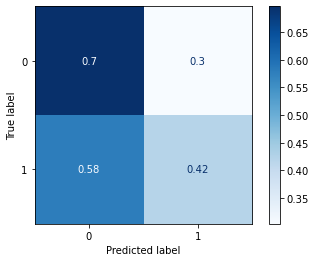

In [98]:
# cross-validation confusion matrix, training data
y_pred = cross_val_predict(logistic_reg_cv.best_estimator_, Xtrain, ytrain, cv=10)
conf_mat = confusion_matrix(ytrain, y_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=logistic_reg_cv.best_estimator_.classes_
                      ).plot(cmap=plt.cm.Blues)

The confusion matrix on the test data:

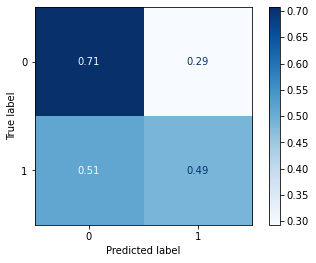

In [99]:
ConfusionMatrixDisplay.from_estimator(logistic_reg_cv.best_estimator_, Xtest, ytest,
                                 display_labels=logistic_reg_cv.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

Here we can see that the model has accurately predict 71% of the non-fatal cases and 49% of the fatal cases. Since we want to emphasize on the fatality, we seek to improve the model's fatality prediction (true negative rate): 

###  Oversampling for logistic regression

In [100]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

pipeline = Pipeline([
        ('smote', SMOTE(random_state=2022)),
        ('log', LogisticRegression(random_state=2022))
    ])

param_grid = [
    {
        'smote__sampling_strategy': [0.5, 0.75, 1.0],
        "log__C": np.logspace(-3,3,7),
        "log__penalty":["l1","l2"],
        'log__class_weight':["balanced"]
    },
]

# we'll use 10-fold cross-validation

log_os_grid_search = GridSearchCV(pipeline, param_grid, cv=10, 
                              scoring='f1_macro',
                              return_train_score=True)

start = time.time()
log_os_grid_search.fit(Xtrain, ytrain)
end = time.time() - start
print("best parameters",log_os_grid_search.best_params_)
print("f-score :",log_os_grid_search.best_score_)
print(f"Took {end} seconds")

best parameters {'log__C': 0.001, 'log__class_weight': 'balanced', 'log__penalty': 'l2', 'smote__sampling_strategy': 0.5}
f-score : 0.4308739527105333
Took 4.77445125579834 seconds


In [101]:
# training and validation RMSE
log_os_cv_results = pd.DataFrame(log_os_grid_search.cv_results_
                         )[['params', 'mean_train_score', 'mean_test_score']]
log_os_cv_results["diff, %"] = 100*(log_os_cv_results["mean_train_score"]-log_os_cv_results["mean_test_score"]
                                                     )/log_os_cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
log_os_cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
3,"{'log__C': 0.001, 'log__class_weight': 'balanced', 'log__penalty': 'l2', 'smote__sampling_strate...",0.442847,0.430874,2.703681
5,"{'log__C': 0.001, 'log__class_weight': 'balanced', 'log__penalty': 'l2', 'smote__sampling_strate...",0.438733,0.429239,2.164057
4,"{'log__C': 0.001, 'log__class_weight': 'balanced', 'log__penalty': 'l2', 'smote__sampling_strate...",0.439109,0.429058,2.288937
11,"{'log__C': 0.01, 'log__class_weight': 'balanced', 'log__penalty': 'l2', 'smote__sampling_strateg...",0.426787,0.415719,2.593197
10,"{'log__C': 0.01, 'log__class_weight': 'balanced', 'log__penalty': 'l2', 'smote__sampling_strateg...",0.426438,0.415627,2.535300
33,"{'log__C': 100.0, 'log__class_weight': 'balanced', 'log__penalty': 'l2', 'smote__sampling_strate...",0.426215,0.415053,2.618993
21,"{'log__C': 1.0, 'log__class_weight': 'balanced', 'log__penalty': 'l2', 'smote__sampling_strategy...",0.426230,0.415053,2.622348
39,"{'log__C': 1000.0, 'log__class_weight': 'balanced', 'log__penalty': 'l2', 'smote__sampling_strat...",0.426215,0.415053,2.618993
27,"{'log__C': 10.0, 'log__class_weight': 'balanced', 'log__penalty': 'l2', 'smote__sampling_strateg...",0.426200,0.415053,2.615584
15,"{'log__C': 0.1, 'log__class_weight': 'balanced', 'log__penalty': 'l2', 'smote__sampling_strategy...",0.426086,0.414790,2.651157


With oversampling, we got slightly worse result than the baseline. The f-score increase from 0.449 to 0.431.

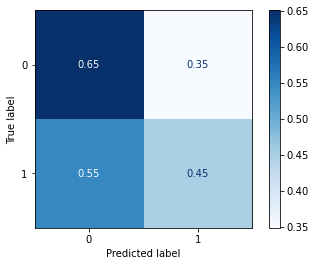

In [102]:
# cross-validation confusion matrix on the training data
y_pred = cross_val_predict(log_os_grid_search.best_estimator_, Xtrain, ytrain, cv=10)
conf_mat = confusion_matrix(ytrain, y_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=log_os_grid_search.best_estimator_.classes_
                      ).plot(cmap=plt.cm.Blues)

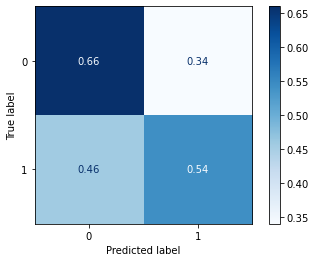

In [103]:
ConfusionMatrixDisplay.from_estimator(log_os_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=log_os_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

Here we can see that the model has accurately predict 66% of the non-fatal cases and 54% of the fatal cases. Oversampling notably improve our logistic regression model for the fatal category, but the overall f-score is worse, of 0.431 compared to 0.496 of the baseline and 0.449 of the original logistic model. 


### Undersampling for logistic regression

In [110]:
#speed up the model by adding n_jobs =-1
from imblearn.under_sampling import ClusterCentroids
from sklearn.model_selection import RandomizedSearchCV
from tune_sklearn import TuneGridSearchCV
pipeline = Pipeline([
        ('cc', ClusterCentroids(random_state=2022)),
        ('log', LogisticRegression(random_state=2022))
    ])


param_grid = [
    {
        'cc__sampling_strategy': [0.5, 0.75, 1.0],
         "log__C": np.logspace(-3,3,7),
        "log__penalty":["l1","l2"],
        'log__class_weight':["balanced"]
    },
]

# we'll use 5-fold cross-validation
log_us_grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs =-1,
                              scoring='f1_macro',
                              return_train_score=True)

start = time.time()
log_us_grid_search.fit(Xtrain, ytrain)
end = time.time() - start
print("best parameters",log_us_grid_search.best_params_)
print(f"Took {end} seconds")

best parameters {'cc__sampling_strategy': 1.0, 'log__C': 100.0, 'log__class_weight': 'balanced', 'log__penalty': 'l2'}
Took 83.60957479476929 seconds


In [111]:
log_us_cv_results = pd.DataFrame(log_us_grid_search.cv_results_
                         )[['params', 'mean_train_score', 'mean_test_score']]
log_us_cv_results["diff, %"] = 100*(log_us_cv_results["mean_train_score"]-log_us_cv_results["mean_test_score"]
                                                     )/log_us_cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
log_us_cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
41,"{'cc__sampling_strategy': 1.0, 'log__C': 1000.0, 'log__class_weight': 'balanced', 'log__penalty'...",0.337186,0.326987,3.024835
39,"{'cc__sampling_strategy': 1.0, 'log__C': 100.0, 'log__class_weight': 'balanced', 'log__penalty':...",0.337152,0.326987,3.015180
37,"{'cc__sampling_strategy': 1.0, 'log__C': 10.0, 'log__class_weight': 'balanced', 'log__penalty': ...",0.337188,0.326699,3.110814
35,"{'cc__sampling_strategy': 1.0, 'log__C': 1.0, 'log__class_weight': 'balanced', 'log__penalty': '...",0.336318,0.325983,3.073084
23,"{'cc__sampling_strategy': 0.75, 'log__C': 10.0, 'log__class_weight': 'balanced', 'log__penalty':...",0.330791,0.322795,2.417301
27,"{'cc__sampling_strategy': 0.75, 'log__C': 1000.0, 'log__class_weight': 'balanced', 'log__penalty...",0.330807,0.322795,2.421925
25,"{'cc__sampling_strategy': 0.75, 'log__C': 100.0, 'log__class_weight': 'balanced', 'log__penalty'...",0.330807,0.322795,2.421864
21,"{'cc__sampling_strategy': 0.75, 'log__C': 1.0, 'log__class_weight': 'balanced', 'log__penalty': ...",0.330596,0.321620,2.715055
13,"{'cc__sampling_strategy': 0.5, 'log__C': 1000.0, 'log__class_weight': 'balanced', 'log__penalty'...",0.325144,0.321030,1.265120
11,"{'cc__sampling_strategy': 0.5, 'log__C': 100.0, 'log__class_weight': 'balanced', 'log__penalty':...",0.325144,0.321030,1.265120


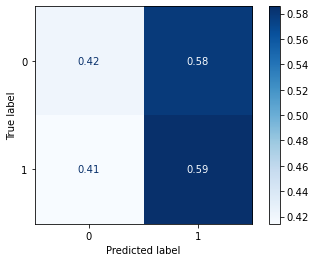

In [113]:
# cross-validation confusion matrix
y_pred = cross_val_predict(log_us_grid_search.best_estimator_, Xtrain, ytrain, cv=10)
conf_mat = confusion_matrix(ytrain, y_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=log_us_grid_search.best_estimator_.classes_
                      ).plot(cmap=plt.cm.Blues)

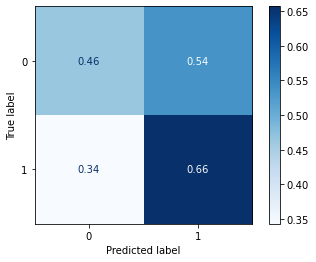

In [114]:
ConfusionMatrixDisplay.from_estimator(log_us_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=log_us_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

## Evaluation

In [107]:
# Unbalanced logistic regression
evaluate_on_test(logistic_reg_cv.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.97      0.71      0.82       942
           1       0.06      0.49      0.10        35

    accuracy                           0.70       977
   macro avg       0.52      0.60      0.46       977
weighted avg       0.94      0.70      0.79       977



In [108]:
# Oversampling logistic regression
evaluate_on_test(log_os_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.97      0.66      0.79       942
           1       0.06      0.54      0.10        35

    accuracy                           0.66       977
   macro avg       0.52      0.60      0.44       977
weighted avg       0.94      0.66      0.76       977



In [115]:
# Undersampling logistic regression
evaluate_on_test(log_us_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.97      0.46      0.63       942
           1       0.04      0.66      0.08        35

    accuracy                           0.47       977
   macro avg       0.51      0.56      0.36       977
weighted avg       0.94      0.47      0.61       977



For logistic regression, using undersampling and oversampling improve the prediction on fatal cases a lot, but also drastically reduce the prediction on the non-fatal case. We want to achieve a balance here.
The f-scores of 3 models are less than that of the baselinem of 0.496. Unbalance logistic regression seems to yield the best results here. 

### 7.2.2 Support Vector Machine

In [116]:
from sklearn.svm import LinearSVC
lsvm = LinearSVC(random_state=2022, max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 0.5, 1, 3, 5, 7, 10],
    'class_weight':['balanced']
}
# we'll use 5-fold cross-validation
linearSVC = GridSearchCV(lsvm, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
linearSVC.fit(Xtrain, ytrain)
end = time.time() - start
print(f"Took {end} seconds")
print("best parameters",linearSVC.best_params_)
print("f-score :",linearSVC.best_score_)

Took 5.60172700881958 seconds
best parameters {'C': 5, 'class_weight': 'balanced'}
f-score : 0.5305692267837259


In [117]:
# training and validation RMSE
lsvm_cv_results = pd.DataFrame(linearSVC.cv_results_
                         )[['params', 'mean_train_score', 'mean_test_score']]
lsvm_cv_results["diff, %"] = 100*(lsvm_cv_results["mean_train_score"]-lsvm_cv_results["mean_test_score"])/lsvm_cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
lsvm_cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
5,"{'C': 5, 'class_weight': 'balanced'}",0.535284,0.530569,0.880816
7,"{'C': 10, 'class_weight': 'balanced'}",0.528929,0.519530,1.777006
6,"{'C': 7, 'class_weight': 'balanced'}",0.513265,0.512125,0.222271
4,"{'C': 3, 'class_weight': 'balanced'}",0.508203,0.502663,1.090140
3,"{'C': 1, 'class_weight': 'balanced'}",0.449453,0.436570,2.866206
2,"{'C': 0.5, 'class_weight': 'balanced'}",0.437487,0.422432,3.441358
0,"{'C': 0.01, 'class_weight': 'balanced'}",0.435936,0.421395,3.335468
1,"{'C': 0.1, 'class_weight': 'balanced'}",0.435538,0.421263,3.277503


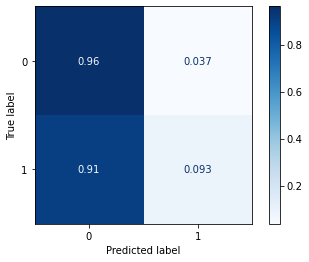

In [118]:
# cross-validation confusion matrix, training data
y_pred_svc = cross_val_predict(linearSVC.best_estimator_, Xtrain, ytrain, cv=5)
conf_mat = confusion_matrix(ytrain, y_pred_svc, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=linearSVC.best_estimator_.classes_
                      ).plot(cmap=plt.cm.Blues)

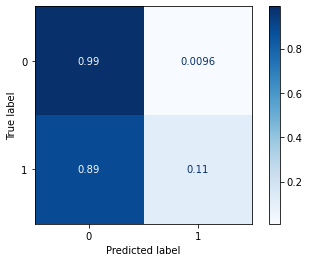

In [119]:
ConfusionMatrixDisplay.from_estimator(linearSVC.best_estimator_, Xtest, ytest,
                                 display_labels=linearSVC.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

While we observe an increase in the overall f-score 0.53 compare to the baseline of 0.496, only 11% of the fatal cases are correctly predicted.

### Oversampling for Support Vector Machine

In [121]:

pipeline = Pipeline([
        ('smote', SMOTE(random_state=2022)),
        ('lsvm', LinearSVC(random_state=2022, max_iter=1000))
    ])

param_grid = [
    {
        'smote__sampling_strategy': [0.5, 0.75, 1.0],
        "lsvm__C": [0.01, 0.1, 0.5, 1, 3, 5, 7, 10],
        'lsvm__class_weight':['balanced']
    },
]

# we'll use 10-fold cross-validation
lsvm_os_grid_search = GridSearchCV(pipeline, param_grid, cv=5, 
                              scoring='f1_macro',
                              return_train_score=True)

#estimate the time needed to run the model
start = time.time()
lsvm_os_grid_search.fit(Xtrain, ytrain)
end = time.time() - start

#Print results
print("best parameters",lsvm_os_grid_search.best_params_)
print("f-score :",lsvm_os_grid_search.best_score_)
print(f"Took {end} seconds")

best parameters {'lsvm__C': 10, 'lsvm__class_weight': 'balanced', 'smote__sampling_strategy': 0.5}
f-score : 0.4217650715278712
Took 29.32716703414917 seconds


In [122]:
cv_results = pd.DataFrame(lsvm_os_grid_search.cv_results_
                         )[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
21,"{'lsvm__C': 10, 'lsvm__class_weight': 'balanced', 'smote__sampling_strategy': 0.5}",0.434981,0.421765,3.038295
22,"{'lsvm__C': 10, 'lsvm__class_weight': 'balanced', 'smote__sampling_strategy': 0.75}",0.432081,0.419849,2.831028
15,"{'lsvm__C': 5, 'lsvm__class_weight': 'balanced', 'smote__sampling_strategy': 0.5}",0.428218,0.417192,2.574799
18,"{'lsvm__C': 7, 'lsvm__class_weight': 'balanced', 'smote__sampling_strategy': 0.5}",0.425659,0.416456,2.161963
1,"{'lsvm__C': 0.01, 'lsvm__class_weight': 'balanced', 'smote__sampling_strategy': 0.75}",0.422825,0.414595,1.946362
12,"{'lsvm__C': 3, 'lsvm__class_weight': 'balanced', 'smote__sampling_strategy': 0.5}",0.426178,0.414413,2.760446
0,"{'lsvm__C': 0.01, 'lsvm__class_weight': 'balanced', 'smote__sampling_strategy': 0.5}",0.425529,0.414361,2.624528
16,"{'lsvm__C': 5, 'lsvm__class_weight': 'balanced', 'smote__sampling_strategy': 0.75}",0.422822,0.413662,2.166608
4,"{'lsvm__C': 0.1, 'lsvm__class_weight': 'balanced', 'smote__sampling_strategy': 0.75}",0.423673,0.413566,2.385616
7,"{'lsvm__C': 0.5, 'lsvm__class_weight': 'balanced', 'smote__sampling_strategy': 0.75}",0.423877,0.413033,2.558395


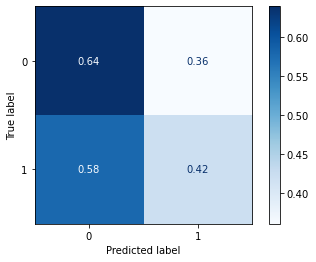

In [123]:
# cross-validation confusion matrix, training data
y_pred_os_lsvm = cross_val_predict(lsvm_os_grid_search.best_estimator_, Xtrain, ytrain, cv=10)
conf_mat = confusion_matrix(ytrain, y_pred_os_lsvm, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=lsvm_os_grid_search.best_estimator_.classes_
                      ).plot(cmap=plt.cm.Blues)

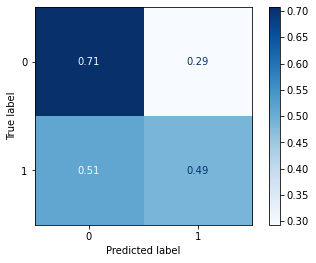

In [124]:
#Confusion matrix on testset
ConfusionMatrixDisplay.from_estimator(lsvm_os_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=lsvm_os_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### Undersampling for Support Vector Machine

In [126]:
pipeline = Pipeline([
        ('cc', ClusterCentroids(random_state=2022)),
        ('lsvm', LinearSVC(random_state=2022, max_iter=1000)),
    ])


param_grid = [
    {
        'cc__sampling_strategy': [0.5, 0.75, 1.0],
         "lsvm__C": [0.01, 0.1, 0.5, 1, 3, 5, 7, 10],
       'lsvm__class_weight':['balanced']
    },
]

# we'll use 10-fold cross-validation
lsvm_us_grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs =-1,
                              scoring='f1_macro',
                              return_train_score=True)

#estimate the time needed to run the model
start = time.time()
lsvm_us_grid_search.fit(Xtrain, ytrain)
end = time.time() - start

#Print results
print("best parameters",lsvm_us_grid_search.best_params_)
print(f"Took {end} seconds")

best parameters {'cc__sampling_strategy': 1.0, 'lsvm__C': 10, 'lsvm__class_weight': 'balanced'}
Took 19.10361671447754 seconds


In [127]:
cv_results = pd.DataFrame(lsvm_us_grid_search.cv_results_
                         )[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
23,"{'cc__sampling_strategy': 1.0, 'lsvm__C': 10, 'lsvm__class_weight': 'balanced'}",0.338325,0.338422,-0.028684
20,"{'cc__sampling_strategy': 1.0, 'lsvm__C': 3, 'lsvm__class_weight': 'balanced'}",0.339682,0.333428,1.841029
19,"{'cc__sampling_strategy': 1.0, 'lsvm__C': 1, 'lsvm__class_weight': 'balanced'}",0.339849,0.332514,2.158284
21,"{'cc__sampling_strategy': 1.0, 'lsvm__C': 5, 'lsvm__class_weight': 'balanced'}",0.338601,0.332161,1.901938
18,"{'cc__sampling_strategy': 1.0, 'lsvm__C': 0.5, 'lsvm__class_weight': 'balanced'}",0.339319,0.331865,2.196639
17,"{'cc__sampling_strategy': 1.0, 'lsvm__C': 0.1, 'lsvm__class_weight': 'balanced'}",0.338386,0.330141,2.436389
22,"{'cc__sampling_strategy': 1.0, 'lsvm__C': 7, 'lsvm__class_weight': 'balanced'}",0.337667,0.329959,2.282925
16,"{'cc__sampling_strategy': 1.0, 'lsvm__C': 0.01, 'lsvm__class_weight': 'balanced'}",0.336590,0.328978,2.261536
15,"{'cc__sampling_strategy': 0.75, 'lsvm__C': 10, 'lsvm__class_weight': 'balanced'}",0.334954,0.327782,2.141366
9,"{'cc__sampling_strategy': 0.75, 'lsvm__C': 0.1, 'lsvm__class_weight': 'balanced'}",0.336926,0.327398,2.828097


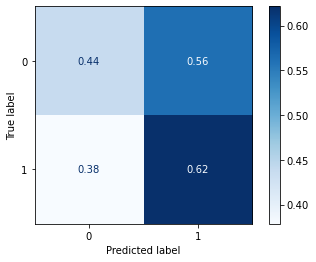

In [128]:
# cross-validation confusion matrix, training data
y_pred_lsvm_us = cross_val_predict(lsvm_us_grid_search.best_estimator_, Xtrain, ytrain, cv=5)
conf_mat = confusion_matrix(ytrain, y_pred_lsvm_us, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=lsvm_us_grid_search.best_estimator_.classes_
                      ).plot(cmap=plt.cm.Blues)

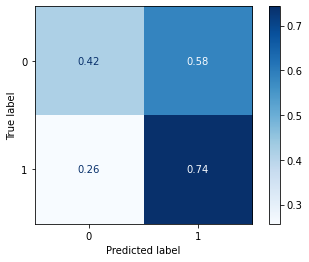

In [129]:
#Confusion matrix on testing data
ConfusionMatrixDisplay.from_estimator(lsvm_us_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=lsvm_us_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

## Evaluation

In [120]:
# Unbalanced SVM
evaluate_on_test(linearSVC.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       942
           1       0.31      0.11      0.17        35

    accuracy                           0.96       977
   macro avg       0.64      0.55      0.57       977
weighted avg       0.94      0.96      0.95       977



In [125]:
# oversampling SVM
evaluate_on_test(lsvm_os_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.97      0.71      0.82       942
           1       0.06      0.49      0.10        35

    accuracy                           0.70       977
   macro avg       0.52      0.60      0.46       977
weighted avg       0.94      0.70      0.79       977



In [130]:
# undersampling SVM
evaluate_on_test(lsvm_us_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.98      0.42      0.58       942
           1       0.05      0.74      0.08        35

    accuracy                           0.43       977
   macro avg       0.51      0.58      0.33       977
weighted avg       0.94      0.43      0.56       977



For Support Vector Machine, it seems that oversampling is performing best here with the right blend of 0.49 for fatal cases and 0.71 for non-fatal cases. 

## 7.2.3 Decision Tree

In [131]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
dec_tree = tree.DecisionTreeClassifier()
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth': [5, None],
    'max_features': ['auto', 'sqrt', 'log2'],
    'ccp_alpha': [0.1, .01, .001],
    'min_samples_split': [2, 3, 4],
    'class_weight':['balanced']
}

# we'll use 10-fold cross-validation
dec_tree_cv = GridSearchCV(dec_tree, param_grid, cv=10,
                           scoring='f1_macro',
                           return_train_score=True) 

#Estimate the time needed to run the model 
start = time.time()
dec_tree_cv.fit(Xtrain, ytrain)
end = time.time() - start

# Print results
print(f"Took {end} seconds")
print("best parameters",dec_tree_cv.best_params_)
print("f-score :",dec_tree_cv.best_score_)

Took 6.542407751083374 seconds
best parameters {'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2}
f-score : 0.5136715021177073


In [132]:
cv_results = pd.DataFrame(dec_tree_cv.cv_results_
                         )[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
102,"{'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max...",0.805561,0.513672,36.234324
101,"{'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max...",0.779326,0.506507,35.007100
99,"{'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max...",0.805772,0.502904,37.587340
104,"{'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max...",0.780759,0.502079,35.693529
100,"{'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max...",0.800317,0.501928,37.283884
...,...,...,...,...
24,"{'ccp_alpha': 0.1, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_feat...",0.217117,0.217146,-0.013444
23,"{'ccp_alpha': 0.1, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_feat...",0.217117,0.217146,-0.013444
22,"{'ccp_alpha': 0.1, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_feat...",0.217117,0.217146,-0.013444
0,"{'ccp_alpha': 0.1, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_feature...",0.217117,0.217146,-0.013444


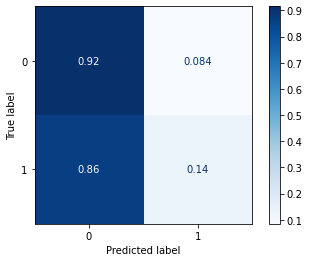

In [133]:
# cross-validation confusion matrix, training data
y_pred_dt = cross_val_predict(dec_tree_cv.best_estimator_, Xtrain, ytrain, cv=10)
conf_mat = confusion_matrix(ytrain, y_pred_dt, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=dec_tree_cv.best_estimator_.classes_
                      ).plot(cmap=plt.cm.Blues)

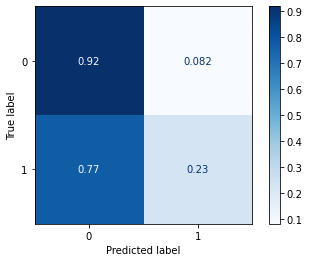

In [134]:
#Confusion matrix on testing data
ConfusionMatrixDisplay.from_estimator(dec_tree_cv.best_estimator_, Xtest, ytest,
                                 display_labels=dec_tree_cv.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### Oversampling for Decision Tree

In [136]:
pipeline = Pipeline([
        ('smote', SMOTE(random_state=2022)),
        ('dt', tree.DecisionTreeClassifier(random_state=2022))
    ])

param_grid = [
    {
        'smote__sampling_strategy': [0.5, 0.75, 1.0],
        'dt__criterion':['gini','entropy'],
    'dt__max_depth': [5, None],
    'dt__max_features': ['auto', 'sqrt', 'log2'],
    'dt__ccp_alpha': [0.1, .01, .001],
    'dt__min_samples_split': [2, 3, 4],
    'dt__class_weight':['balanced']
    },
]

# we'll use 10-fold cross-validation
dt_os_grid_search = GridSearchCV(pipeline, param_grid, cv=10, 
                              scoring='f1_macro',
                              return_train_score=True)

#estimate the time needed to run the model
start = time.time()
dt_os_grid_search.fit(Xtrain, ytrain)
end = time.time() - start

#Print results
print("best parameters",dt_os_grid_search.best_params_)
print("f-score :",dt_os_grid_search.best_score_)
print(f"Took {end} seconds")

best parameters {'dt__ccp_alpha': 0.001, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_depth': None, 'dt__max_features': 'auto', 'dt__min_samples_split': 2, 'smote__sampling_strategy': 0.5}
f-score : 0.5133857423188736
Took 44.79985308647156 seconds


In [137]:
# training and validation RMSE
dt_os_cv_results = pd.DataFrame(dt_os_grid_search.cv_results_
                         )[['params', 'mean_train_score', 'mean_test_score']]
dt_os_cv_results["diff, %"] = 100*(dt_os_cv_results["mean_train_score"]-dt_os_cv_results["mean_test_score"]
                                                     )/dt_os_cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
dt_os_cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
297,"{'dt__ccp_alpha': 0.001, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_de...",0.653006,0.513386,21.381148
306,"{'dt__ccp_alpha': 0.001, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_de...",0.653006,0.513386,21.381148
315,"{'dt__ccp_alpha': 0.001, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_de...",0.653006,0.513386,21.381148
311,"{'dt__ccp_alpha': 0.001, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_de...",0.638591,0.512392,19.762113
302,"{'dt__ccp_alpha': 0.001, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_de...",0.638591,0.512392,19.762113
...,...,...,...,...
84,"{'dt__ccp_alpha': 0.1, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_dept...",0.308373,0.308344,0.009454
66,"{'dt__ccp_alpha': 0.1, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_dept...",0.308373,0.308344,0.009454
63,"{'dt__ccp_alpha': 0.1, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_dept...",0.308373,0.308344,0.009454
60,"{'dt__ccp_alpha': 0.1, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_dept...",0.308373,0.308344,0.009454


the model seems to have overfitting problem. 

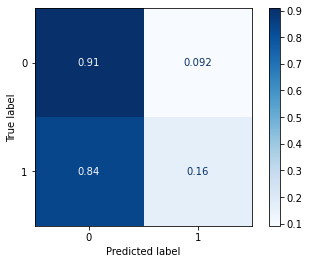

In [138]:
# cross-validation confusion matrix, training data
y_pred_os_dt = cross_val_predict(dt_os_grid_search.best_estimator_, Xtrain, ytrain, cv=10)
conf_mat = confusion_matrix(ytrain, y_pred_os_dt, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=dt_os_grid_search.best_estimator_.classes_
                      ).plot(cmap=plt.cm.Blues)

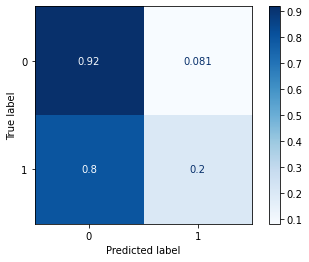

In [139]:
#Confusion matrix on testing data
ConfusionMatrixDisplay.from_estimator(dt_os_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=dt_os_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### Undersampling for Decision Tree

In [141]:
pipeline = Pipeline([
        ('cc', ClusterCentroids(random_state=2022)),
        ('dt', tree.DecisionTreeClassifier(random_state=2022))
    ])


param_grid = [
    {
        'cc__sampling_strategy': [0.5, 0.75, 1.0],
        'dt__criterion':['gini','entropy'],
        'dt__max_depth': [5, None],
        'dt__ccp_alpha': [0.1, .01, .001],
        'dt__class_weight':['balanced']       
    },
]

# we'll use 10-fold cross-validation
dt_us_grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs =-1,
                              scoring='f1_macro',
                              return_train_score=True)

#estimate the time needed to run the model
start = time.time()
dt_us_grid_search.fit(Xtrain, ytrain)
end = time.time() - start

#Print results
print("best parameters",dt_us_grid_search.best_params_)
print("f-score :",dt_us_grid_search.best_score_)
print(f"Took {end} seconds")

best parameters {'cc__sampling_strategy': 0.5, 'dt__ccp_alpha': 0.1, 'dt__class_weight': 'balanced', 'dt__criterion': 'gini', 'dt__max_depth': 5}
f-score : 0.49087113794604004
Took 76.58957195281982 seconds


In [142]:
# training and validation RMSE
dt_us_cv_results = pd.DataFrame(dt_us_grid_search.cv_results_
                         )[['params', 'mean_train_score', 'mean_test_score']]
dt_us_cv_results["diff, %"] = 100*(dt_us_cv_results["mean_train_score"]-dt_us_cv_results["mean_test_score"]
                                                     )/dt_us_cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
dt_us_cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
0,"{'cc__sampling_strategy': 0.5, 'dt__ccp_alpha': 0.1, 'dt__class_weight': 'balanced', 'dt__criter...",0.490871,0.490871,0.000003
2,"{'cc__sampling_strategy': 0.5, 'dt__ccp_alpha': 0.1, 'dt__class_weight': 'balanced', 'dt__criter...",0.490871,0.490871,0.000003
3,"{'cc__sampling_strategy': 0.5, 'dt__ccp_alpha': 0.1, 'dt__class_weight': 'balanced', 'dt__criter...",0.490871,0.490871,0.000003
1,"{'cc__sampling_strategy': 0.5, 'dt__ccp_alpha': 0.1, 'dt__class_weight': 'balanced', 'dt__criter...",0.490871,0.490871,0.000003
24,"{'cc__sampling_strategy': 1.0, 'dt__ccp_alpha': 0.1, 'dt__class_weight': 'balanced', 'dt__criter...",0.490871,0.490871,0.000003
25,"{'cc__sampling_strategy': 1.0, 'dt__ccp_alpha': 0.1, 'dt__class_weight': 'balanced', 'dt__criter...",0.490871,0.490871,0.000003
26,"{'cc__sampling_strategy': 1.0, 'dt__ccp_alpha': 0.1, 'dt__class_weight': 'balanced', 'dt__criter...",0.366113,0.361941,1.139494
27,"{'cc__sampling_strategy': 1.0, 'dt__ccp_alpha': 0.1, 'dt__class_weight': 'balanced', 'dt__criter...",0.366113,0.361941,1.139494
9,"{'cc__sampling_strategy': 0.5, 'dt__ccp_alpha': 0.001, 'dt__class_weight': 'balanced', 'dt__crit...",0.340309,0.302838,11.010902
10,"{'cc__sampling_strategy': 0.5, 'dt__ccp_alpha': 0.001, 'dt__class_weight': 'balanced', 'dt__crit...",0.300179,0.285134,5.011840


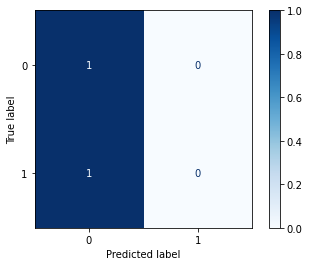

In [143]:
# cross-validation confusion matrix, training data
y_pred_us_dt = cross_val_predict(dt_us_grid_search.best_estimator_, Xtrain, ytrain, cv=10)
conf_mat = confusion_matrix(ytrain, y_pred_us_dt, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=dt_us_grid_search.best_estimator_.classes_
                      ).plot(cmap=plt.cm.Blues)

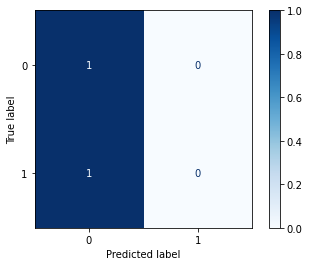

In [144]:
#Confusion matrix on testing data
ConfusionMatrixDisplay.from_estimator(dt_us_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=dt_us_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

## Evaluation

In [135]:
# Unbalanced decision tree
evaluate_on_test(dec_tree_cv.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       942
           1       0.09      0.23      0.13        35

    accuracy                           0.89       977
   macro avg       0.53      0.57      0.54       977
weighted avg       0.94      0.89      0.91       977



In [140]:
# Oversampling decision tree
evaluate_on_test(dt_os_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       942
           1       0.08      0.20      0.12        35

    accuracy                           0.89       977
   macro avg       0.53      0.56      0.53       977
weighted avg       0.94      0.89      0.91       977



In [145]:
# Undersampling decision tree
evaluate_on_test(dt_us_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       942
           1       0.00      0.00      0.00        35

    accuracy                           0.96       977
   macro avg       0.48      0.50      0.49       977
weighted avg       0.93      0.96      0.95       977



We will not consider any Decision Tree model in our final model evaluation because 
1. Unbalanced decision tree model and oversampling decision tree model have overfitting problem
2. Undersampling decision tree did not predict correctly any fatal cases.

## 7.2.4 Random Forest

In [146]:
from sklearn.ensemble import RandomForestClassifier

# specify the hyperparameters and their values
param_grid = [
    {'n_estimators': [100, 200, 500],
     'max_depth': [5, None],
    'class_weight': ['balanced_subsample']}
]

forest = RandomForestClassifier(random_state=2022)

rf_grid_search = GridSearchCV(forest, param_grid, cv=10, 
                              scoring='f1_macro',
                              return_train_score=True)

#estimate the time needed to run the model
start = time.time()
rf_grid_search.fit(Xtrain, ytrain)
end = time.time() - start


#Print results
print("best parameters",rf_grid_search.best_params_)
print("f-score :",rf_grid_search.best_score_)
print(f"Took {end} seconds")

best parameters {'class_weight': 'balanced_subsample', 'max_depth': 5, 'n_estimators': 200}
f-score : 0.4935450589691556
Took 38.535414934158325 seconds


In [147]:
# training and validation RMSE
rf_cv_results = pd.DataFrame(rf_grid_search.cv_results_
                         )[['params', 'mean_train_score', 'mean_test_score']]
rf_cv_results["diff, %"] = 100*(rf_cv_results["mean_train_score"]-rf_cv_results["mean_test_score"]
                                                     )/rf_cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
rf_cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
1,"{'class_weight': 'balanced_subsample', 'max_depth': 5, 'n_estimators': 200}",0.566382,0.493545,12.859984
2,"{'class_weight': 'balanced_subsample', 'max_depth': 5, 'n_estimators': 500}",0.564342,0.489531,13.256331
0,"{'class_weight': 'balanced_subsample', 'max_depth': 5, 'n_estimators': 100}",0.560780,0.489469,12.716417
4,"{'class_weight': 'balanced_subsample', 'max_depth': None, 'n_estimators': 200}",0.955782,0.488735,48.865446
5,"{'class_weight': 'balanced_subsample', 'max_depth': None, 'n_estimators': 500}",0.957228,0.488735,48.942683
3,"{'class_weight': 'balanced_subsample', 'max_depth': None, 'n_estimators': 100}",0.957015,0.488735,48.931336


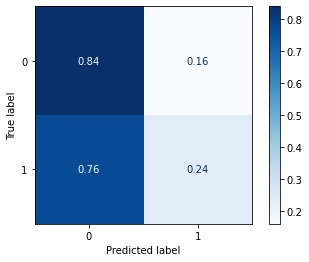

In [148]:
# cross-validation confusion matrix, training data
y_pred_rf = cross_val_predict(rf_grid_search.best_estimator_, Xtrain, ytrain, cv=10)
conf_mat = confusion_matrix(ytrain, y_pred_rf, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=rf_grid_search.best_estimator_.classes_
                      ).plot(cmap=plt.cm.Blues)

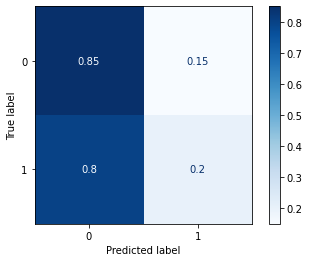

In [149]:
#Confusion matrix on testing data
ConfusionMatrixDisplay.from_estimator(rf_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=rf_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### Oversampling for Random Forest

In [183]:
pipeline = Pipeline([
        ('smote', SMOTE(random_state=2022)),
        ('rf', RandomForestClassifier(random_state=2022))
    ])

param_grid = [
    {
        'smote__sampling_strategy': [0.5, 0.75, 1.0],
        'rf__n_estimators': [100, 200, 500],
        'rf__max_depth': [5, None],
        'rf__class_weight': ['balanced']
    },
]

# we'll use 10-fold cross-validation
rf_os_grid_search = GridSearchCV(pipeline, param_grid, cv=10, 
                              scoring='f1_macro',
                              return_train_score=True)

#estimate the time needed to run the model
start = time.time()
rf_os_grid_search.fit(Xtrain, ytrain)
end = time.time() - start

#Print results
print("best parameters",rf_os_grid_search.best_params_)
print("f-score :",rf_os_grid_search.best_score_)
print(f"Took {end} seconds")

best parameters {'rf__class_weight': 'balanced', 'rf__max_depth': None, 'rf__n_estimators': 100, 'smote__sampling_strategy': 0.75}
f-score : 0.5254716148967321
Took 4245.5265510082245 seconds


In [147]:
# training and validation RMSE
rf_os_cv_results = pd.DataFrame(rf_os_grid_search.cv_results_
                         )[['params', 'mean_train_score', 'mean_test_score']]
rf_os_cv_results["diff, %"] = 100*(rf_os_cv_results["mean_train_score"]-rf_os_cv_results["mean_test_score"]
                                                     )/rf_os_cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
rf_os_cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
10,"{'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None, 'rf__n_estimators': 100, 'smot...",0.981965,0.526716,46.360947
17,"{'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None, 'rf__n_estimators': 500, 'smot...",0.981829,0.522822,46.750255
16,"{'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None, 'rf__n_estimators': 500, 'smot...",0.981961,0.522015,46.839517
9,"{'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None, 'rf__n_estimators': 100, 'smot...",0.982072,0.519437,47.108066
13,"{'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None, 'rf__n_estimators': 200, 'smot...",0.981948,0.518150,47.232410
15,"{'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None, 'rf__n_estimators': 500, 'smot...",0.982101,0.515056,47.555690
14,"{'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None, 'rf__n_estimators': 200, 'smot...",0.981829,0.512926,47.758114
11,"{'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None, 'rf__n_estimators': 100, 'smot...",0.981872,0.508521,48.209021
12,"{'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None, 'rf__n_estimators': 200, 'smot...",0.982041,0.508281,48.242344
1,"{'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 5, 'rf__n_estimators': 100, 'smote__...",0.485211,0.462026,4.778351


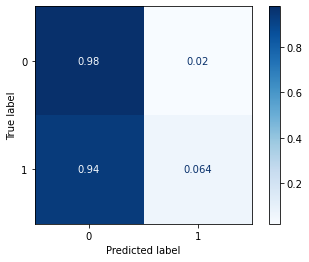

In [148]:
# cross-validation confusion matrix, training data
y_pred_os_rf = cross_val_predict(rf_os_grid_search.best_estimator_, Xtrain, ytrain, cv=10)
conf_mat = confusion_matrix(ytrain, y_pred_os_rf, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=rf_os_grid_search.best_estimator_.classes_
                      ).plot(cmap=plt.cm.Blues)

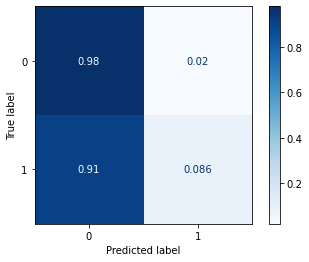

In [149]:
#Confusion matrix on testing data
ConfusionMatrixDisplay.from_estimator(rf_os_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=rf_os_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

We will not consider the oversampling for Random Forest because of the low prediction accuracy for fatal cases and overfitting problem.

### Undersampling for Random Forest

In [150]:
pipeline = Pipeline([
        ('cc', ClusterCentroids(random_state=2022)),
        ('rf', RandomForestClassifier(random_state=2022))
    ])


param_grid = [
    {
        'cc__sampling_strategy': [0.5, 0.75, 1.0],
        'rf__n_estimators': [100, 200, 500],
        'rf__max_depth': [5, None],
        'rf__class_weight': ['balanced_subsample']
       
    },
]

# we'll use 10-fold cross-validation
rf_us_grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs =-1,
                              scoring='f1_macro',
                              return_train_score=True)

#estimate the time needed to run the model
start = time.time()
rf_us_grid_search.fit(Xtrain, ytrain)
end = time.time() - start

#Print results
print("best parameters",rf_us_grid_search.best_params_)
print("f-score :",rf_us_grid_search.best_score_)
print(f"Took {end} seconds")

best parameters {'cc__sampling_strategy': 0.5, 'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None, 'rf__n_estimators': 200}
f-score : 0.37233998095447884
Took 23.39723515510559 seconds


In [151]:
# training and validation RMSE
rf_us_cv_results = pd.DataFrame(rf_us_grid_search.cv_results_
                         )[['params', 'mean_train_score', 'mean_test_score']]
rf_us_cv_results["diff, %"] = 100*(rf_us_cv_results["mean_train_score"]-rf_us_cv_results["mean_test_score"]
                                                     )/rf_us_cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
rf_us_cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
4,"{'cc__sampling_strategy': 0.5, 'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None, ...",0.421082,0.372340,11.575362
5,"{'cc__sampling_strategy': 0.5, 'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None, ...",0.421155,0.371144,11.874643
3,"{'cc__sampling_strategy': 0.5, 'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None, ...",0.416863,0.370349,11.158051
0,"{'cc__sampling_strategy': 0.5, 'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 5, 'rf...",0.307395,0.287364,6.516434
1,"{'cc__sampling_strategy': 0.5, 'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 5, 'rf...",0.310469,0.287245,7.480327
2,"{'cc__sampling_strategy': 0.5, 'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 5, 'rf...",0.307657,0.285017,7.358781
11,"{'cc__sampling_strategy': 0.75, 'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None,...",0.261728,0.238299,8.951698
9,"{'cc__sampling_strategy': 0.75, 'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None,...",0.262053,0.236688,9.679415
10,"{'cc__sampling_strategy': 0.75, 'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None,...",0.261184,0.236348,9.508914
7,"{'cc__sampling_strategy': 0.75, 'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 5, 'r...",0.223992,0.212522,5.120556


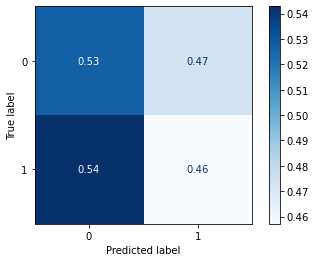

In [153]:
# cross-validation confusion matrix, training data
y_pred_us_rf = cross_val_predict(rf_us_grid_search.best_estimator_, Xtrain, ytrain, cv=5)
conf_mat = confusion_matrix(ytrain, y_pred_us_rf, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=rf_us_grid_search.best_estimator_.classes_
                      ).plot(cmap=plt.cm.Blues)

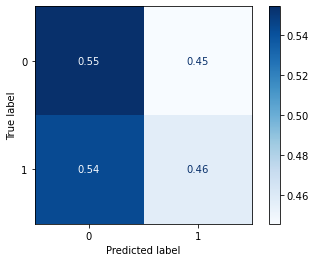

In [154]:
#Confusion matrix on testing data
ConfusionMatrixDisplay.from_estimator(rf_us_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=rf_us_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

## Evaluation

In [155]:
# Unbalanced random forest
evaluate_on_test(rf_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.97      0.85      0.90       942
           1       0.05      0.20      0.08        35

    accuracy                           0.83       977
   macro avg       0.51      0.52      0.49       977
weighted avg       0.93      0.83      0.87       977



In [156]:
# Undersampling random forest
evaluate_on_test(rf_us_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.96      0.55      0.70       942
           1       0.04      0.46      0.07        35

    accuracy                           0.55       977
   macro avg       0.50      0.51      0.39       977
weighted avg       0.93      0.55      0.68       977



## 7.2.5 Light GBM

Light GBM is set up to work with moderate-size dataset, so with a small dataset like this one, it can perform poorly. After testing and hypertuning different parameters, this is the best parameter combination that I found for lightgbm

In [157]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
lgb=lgb.LGBMClassifier(random_state = 2022,objective='binary')
param_grid = {
    'num_leaves':[7],
    'max_depth':[2,63],
    'bagging_freq': [1],
    'scale_pos_weight':[26.83],#adjust the weights of the unbalanced class
    'colsample_bytree': [0.4, 1],
    'min_child_weight': [0.01, 3.9],
    'boost_from_average':[False],
    } 


# we'll use 10-fold cross-validation
lgb_cv = GridSearchCV(lgb, param_grid, cv=5,
                           scoring='f1_macro',
                           return_train_score=True) 

#Estimate the time needed to run the model 
start = time.time()
lgb_cv.fit(Xtrain, ytrain)
end = time.time() - start

# Print results
print(f"Took {end} seconds")
print("best parameters",lgb_cv.best_params_)
print("f-score :",lgb_cv.best_score_)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging

In [158]:
# training and validation RMSE
lgb_cv_results = pd.DataFrame(lgb_cv.cv_results_
                         )[['params', 'mean_train_score', 'mean_test_score']]
lgb_cv_results["diff, %"] = 100*(lgb_cv_results["mean_train_score"]-lgb_cv_results["mean_test_score"]
                                                     )/lgb_cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
lgb_cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
7,"{'bagging_freq': 1, 'boost_from_average': False, 'colsample_bytree': 1, 'max_depth': 63, 'min_ch...",0.570372,0.475894,16.564201
6,"{'bagging_freq': 1, 'boost_from_average': False, 'colsample_bytree': 1, 'max_depth': 63, 'min_ch...",0.567284,0.470483,17.064026
3,"{'bagging_freq': 1, 'boost_from_average': False, 'colsample_bytree': 0.4, 'max_depth': 63, 'min_...",0.543202,0.469516,13.565123
2,"{'bagging_freq': 1, 'boost_from_average': False, 'colsample_bytree': 0.4, 'max_depth': 63, 'min_...",0.542933,0.469240,13.573170
4,"{'bagging_freq': 1, 'boost_from_average': False, 'colsample_bytree': 1, 'max_depth': 2, 'min_chi...",0.482785,0.437947,9.287218
5,"{'bagging_freq': 1, 'boost_from_average': False, 'colsample_bytree': 1, 'max_depth': 2, 'min_chi...",0.479776,0.436691,8.980164
1,"{'bagging_freq': 1, 'boost_from_average': False, 'colsample_bytree': 0.4, 'max_depth': 2, 'min_c...",0.473806,0.435556,8.072986
0,"{'bagging_freq': 1, 'boost_from_average': False, 'colsample_bytree': 0.4, 'max_depth': 2, 'min_c...",0.472820,0.434704,8.061600


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


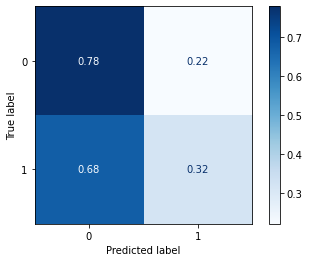

In [160]:
# cross-validation confusion matrix, training data
y_pred_lgb = cross_val_predict(lgb_cv.best_estimator_, Xtrain, ytrain, cv=5)
conf_mat = confusion_matrix(ytrain, y_pred_lgb, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=lgb_cv.best_estimator_.classes_
                      ).plot(cmap=plt.cm.Blues)

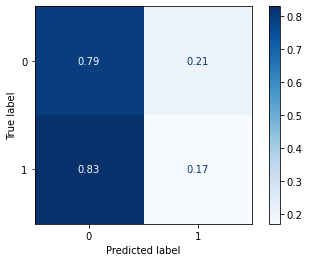

In [161]:
#Confusion matrix on testing data
ConfusionMatrixDisplay.from_estimator(lgb_cv.best_estimator_, Xtest, ytest,
                                 display_labels=lgb_cv.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### Oversampling for Light GBM

In [163]:
pipeline = Pipeline([
        ('smote', SMOTE(random_state=2022)),
        ('lgb', LGBMClassifier(random_state = 2022,objective='binary'))
    ])

param_grid = [
    {
        'smote__sampling_strategy': [0.5, 0.75, 1.0],
        'lgb__num_leaves':[7],
        'lgb__max_depth':[2,63],
        'lgb__bagging_freq': [1],
        'lgb__scale_pos_weight':[26.82],#adjust the weights of the unbalanced class
        'lgb__colsample_bytree': [0.4, 1],
        'lgb__min_child_weight': [0.01, 3.9],
        'lgb__boost_from_average':[False],
    },
]

# we'll use 10-fold cross-validation
lgb_os_grid_search = GridSearchCV(pipeline, param_grid, cv=5, 
                              scoring='f1_macro',
                              return_train_score=True)

#estimate the time needed to run the model
start = time.time()
lgb_os_grid_search.fit(Xtrain, ytrain)
end = time.time() - start

#Print results
print("best parameters",lgb_os_grid_search.best_params_)
print("f-score :",lgb_os_grid_search.best_score_)
print(f"Took {end} seconds")

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging

In [165]:
# training and validation RMSE
lgb_os_cv_results = pd.DataFrame(lgb_os_grid_search.cv_results_
                         )[['params', 'mean_train_score', 'mean_test_score']]
lgb_os_cv_results["diff, %"] = 100*(lgb_os_cv_results["mean_train_score"]-lgb_os_cv_results["mean_test_score"]
                                                     )/lgb_os_cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
lgb_os_cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
21,"{'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__colsample_bytree': 1, 'lgb__max...",0.400937,0.367900,8.240031
18,"{'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__colsample_bytree': 1, 'lgb__max...",0.401633,0.367712,8.445779
19,"{'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__colsample_bytree': 1, 'lgb__max...",0.391794,0.357834,8.667873
22,"{'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__colsample_bytree': 1, 'lgb__max...",0.392218,0.356971,8.986566
20,"{'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__colsample_bytree': 1, 'lgb__max...",0.385419,0.356327,7.548342
23,"{'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__colsample_bytree': 1, 'lgb__max...",0.382251,0.356040,6.857019
6,"{'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__colsample_bytree': 0.4, 'lgb__m...",0.368122,0.340972,7.375345
9,"{'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__colsample_bytree': 0.4, 'lgb__m...",0.368122,0.340972,7.375345
7,"{'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__colsample_bytree': 0.4, 'lgb__m...",0.353598,0.331070,6.371332
10,"{'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__colsample_bytree': 0.4, 'lgb__m...",0.351676,0.330147,6.121984


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


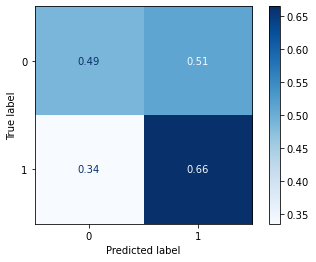

In [166]:
# cross-validation confusion matrix, training data
y_pred_os_lgb = cross_val_predict(lgb_os_grid_search.best_estimator_, Xtrain, ytrain, cv=5)
conf_mat = confusion_matrix(ytrain, y_pred_os_lgb, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=lgb_os_grid_search.best_estimator_.classes_
                      ).plot(cmap=plt.cm.Blues)

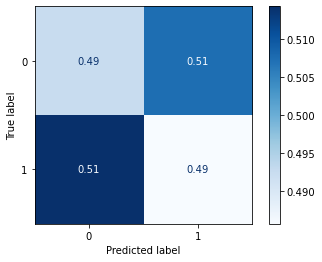

In [167]:
#Confusion matrix on testing data
ConfusionMatrixDisplay.from_estimator(lgb_os_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=lgb_os_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### Undersampling for Light GBM

In [168]:
pipeline = Pipeline([
        ('cc', ClusterCentroids(random_state=2022)),
        ('lgb', LGBMClassifier(random_state = 2022))
    ])


param_grid = [
    {
        'cc__sampling_strategy': [0.5, 0.75, 1.0],
        'lgb__num_leaves':[7],
        'lgb__max_depth':[2,63],
        'lgb__bagging_freq': [1],
        'lgb__scale_pos_weight':[2.82],#adjust the weights of the unbalanced class
        'lgb__colsample_bytree': [0.4, 1],
        'lgb__min_child_weight': [0.01, 3.9],
        'lgb__boost_from_average':[False],
       
    },
]

# we'll use 10-fold cross-validation
lgb_us_grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs =-1,
                              scoring='f1_macro',
                              return_train_score=True)

#estimate the time needed to run the model
start = time.time()
lgb_us_grid_search.fit(Xtrain, ytrain)
end = time.time() - start

#Print results
print("best parameters",lgb_us_grid_search.best_params_)
print("f-score :",lgb_us_grid_search.best_score_)
print(f"Took {end} seconds")

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
best parameters {'cc__sampling_strategy': 0.5, 'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__colsample_bytree': 1, 'lgb__max_depth': 63, 'lgb__min_child_weight': 3.9, 'lgb__num_leaves': 7, 'lgb__scale_pos_weight': 2.82}
f-score : 0.14300742051961254
Took 20.64085292816162 seconds


In [169]:
# training and validation RMSE
lgb_us_cv_results = pd.DataFrame(lgb_us_grid_search.cv_results_
                         )[['params', 'mean_train_score', 'mean_test_score']]
lgb_us_cv_results["diff, %"] = 100*(lgb_us_cv_results["mean_train_score"]-lgb_us_cv_results["mean_test_score"]
                                                     )/lgb_us_cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
lgb_us_cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
7,"{'cc__sampling_strategy': 0.5, 'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__c...",0.157569,0.143007,9.241349
6,"{'cc__sampling_strategy': 0.5, 'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__c...",0.150750,0.135883,9.862243
3,"{'cc__sampling_strategy': 0.5, 'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__c...",0.133243,0.122375,8.156561
2,"{'cc__sampling_strategy': 0.5, 'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__c...",0.127514,0.115812,9.177298
4,"{'cc__sampling_strategy': 0.5, 'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__c...",0.114485,0.103950,9.202013
5,"{'cc__sampling_strategy': 0.5, 'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__c...",0.114763,0.102148,10.992506
1,"{'cc__sampling_strategy': 0.5, 'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__c...",0.109209,0.097956,10.303566
0,"{'cc__sampling_strategy': 0.5, 'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__c...",0.108572,0.097460,10.235004
15,"{'cc__sampling_strategy': 0.75, 'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__...",0.103033,0.090230,12.426324
14,"{'cc__sampling_strategy': 0.75, 'lgb__bagging_freq': 1, 'lgb__boost_from_average': False, 'lgb__...",0.086970,0.081860,5.875228


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


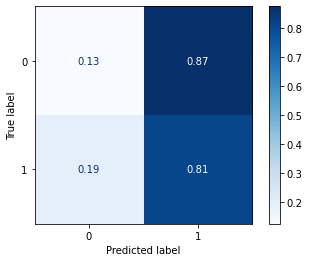

In [170]:
# cross-validation confusion matrix, training data
y_pred_us_lgb = cross_val_predict(lgb_us_grid_search.best_estimator_, Xtrain, ytrain, cv=5)
conf_mat = confusion_matrix(ytrain, y_pred_us_lgb, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=lgb_us_grid_search.best_estimator_.classes_
                      ).plot(cmap=plt.cm.Blues)

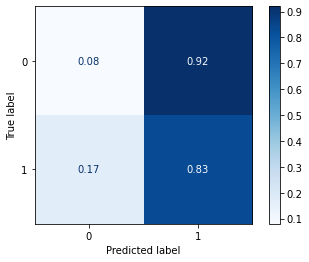

In [171]:
#Confusion matrix on testing data
ConfusionMatrixDisplay.from_estimator(lgb_us_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=lgb_us_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

# Evaluation

In [162]:
# Unbalanced light GBM
evaluate_on_test(lgb_cv.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.96      0.79      0.87       942
           1       0.03      0.17      0.05        35

    accuracy                           0.77       977
   macro avg       0.50      0.48      0.46       977
weighted avg       0.93      0.77      0.84       977



In [173]:
# Oversampling light GBM
evaluate_on_test(lgb_os_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.96      0.49      0.65       942
           1       0.03      0.49      0.06        35

    accuracy                           0.49       977
   macro avg       0.50      0.49      0.36       977
weighted avg       0.93      0.49      0.63       977



In [172]:
# Undersampling light GBM
evaluate_on_test(lgb_us_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.93      0.08      0.15       942
           1       0.03      0.83      0.06        35

    accuracy                           0.11       977
   macro avg       0.48      0.45      0.10       977
weighted avg       0.89      0.11      0.14       977



# 8. Conclusion

From the extensive test, I found 2 models that perform the best with my current dataset:

In [174]:
# oversampling SVM
evaluate_on_test(lsvm_os_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.97      0.71      0.82       942
           1       0.06      0.49      0.10        35

    accuracy                           0.70       977
   macro avg       0.52      0.60      0.46       977
weighted avg       0.94      0.70      0.79       977



In [175]:
# Unbalanced logistic regression
evaluate_on_test(logistic_reg_cv.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.97      0.71      0.82       942
           1       0.06      0.49      0.10        35

    accuracy                           0.70       977
   macro avg       0.52      0.60      0.46       977
weighted avg       0.94      0.70      0.79       977



While both models outperform the other models in this dataset, the mean f-score is only approximately 0.45, which is still below the baseline model's 0.496 score. We should choose logistic regression over the oversampling SVM because it is much easier and quicker to implement.
My sample is substantially smaller than the original dataset since I only want to look at the fatality rate for people over 75. Some models, such as Light GBM, are designed to function with moderate to large datasets, hence they may perform poorly and be prone to overfitting when used with a small dataset.

# 9. Possible Future Improvement

This research can be expanded and applied to other age groups. More importantly, the methods to run the models should also be upgraded. Logistic Regression works best with a small data sample size, so when the dataset is enlarged, Light GBM or other Gradient Boost model might be more appropriate. 
In addition, insurance firms can now collect more sophisticated data, such as telematics or sensor device data, to better forecast the driver's behaviour and lower the risk of causing a fatal accident.